# Notebook to reproduce the results presented in 

Triadic influence as a proxy for compatibility in social relationships, Ruíz-García, M., Ozaita, J., Pereda, M., Alfonso, A., Branas-Garza, P., Cuesta, J. A., and Sánchez, A., Proceedings of the National Academy of Sciences, XXX



Importing packages

In [1]:
import seaborn as sns
import csv
import os
import numpy as np
from sklearn import svm
import networkx as nx
import pylab

import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

Downloading the data from Zenodo (https://zenodo.org/record/7647000#.Y-8kEezMLPC)

In [2]:
!pip install wget
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=3aab08c4ab5e4c88f7f6598d9c90cb80ab04d72c4bfd409ef6ab0e39a1ff5088
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
specific_schools = ['t11_10', 't11_9', 't11_8', 't11_7', 't11_6', 't11_5', 't11_4', 't11_3', 't11_2', 't11_1', 't1', 't2', 't6']

for school_id in specific_schools:
    wget.download('https://zenodo.org/record/7647000/files/Nodes_{}.csv?download=1'.format(school_id))

for school_id in specific_schools:
    wget.download('https://zenodo.org/record/7647000/files/Edges_{}.csv?download=1'.format(school_id))

In [4]:
dict_nodes = {}
for file in os.listdir():
    if file.endswith(".csv") and file[0:5]=='Nodes':
        dict_nodes[file[6:-4]] = pd.read_csv(file)

dict_edges = {}
for file in os.listdir():
    if file.endswith(".csv") and file[0:5]=='Edges':
        dict_edges[file[6:-4]] = pd.read_csv(file)

### Preprocessing the data

Remove students that have Nan values

In [5]:
nodes_clean_dict = {}
total_removed_students = 0
total_students = 0
for key_ind in specific_schools: 
    
    nodes_i = dict_nodes[key_ind]
    nodes_s = nodes_i[["ID","prosocial","Sexo","crttotal"]] 
    # REMOVE STUDENTS WITH NANs
    nodes_clean = nodes_s.dropna(subset=["ID","prosocial","Sexo","crttotal"])
    ### DROPPED STUDENTS
    only_na_mh_col_3 = nodes_s[~nodes_s.index.isin(nodes_clean.index)]
    removed_students_mh_col_3 = list(only_na_mh_col_3.ID)
    total_removed_students += len(removed_students_mh_col_3)
    total_students += np.shape(nodes_s)[0]
    node_feature_dim= nodes_clean.shape[1]-1
    nodes_clean_dict[key_ind] = nodes_clean

print('total_removed_students',total_removed_students)
print('total_students',total_students)
print('total_students-total_removed_students',total_students-total_removed_students)

total_removed_students 119
total_students 3514
total_students-total_removed_students 3395


Check that the IDs are unique

In [6]:
 ### STUDENTS WITH THE SAME ID??? ###

nodes_id_test = np.array([])
for key_ind in dict_nodes.keys():
    nodes_i = dict_nodes[key_ind]
    nodes_id_test = np.concatenate((nodes_id_test,np.array(nodes_i[["ID"]].values.flatten())) )#" Future "," CRT ",

uuu, ccc = np.unique(nodes_id_test, return_counts=True)
dup = uuu[ccc > 1]

print('REPEATED STUDENTS?', dup)

REPEATED STUDENTS? []


Keep only the edges that connect nodes with personal information

In [7]:

dir_edges_all_dict = {}

for key_ind in specific_schools: #dict_nodes.keys():

    edges_i = dict_edges[key_ind]
    nodes_i = nodes_clean_dict[key_ind]

    # SOME STUDENTS APPEAR IN THE EDGES BUT NOT IN THE NODE FILES
    all_nodes_in_edges = np.unique(list(edges_i['from'])+list(edges_i['to']))

    students_school = list(nodes_i['ID'])
    removed_students_extra = list(set(students_school).symmetric_difference(set(all_nodes_in_edges)))

    #keep only edges connecting nodes with personal information
    data_edges_clean = edges_i[(~edges_i['from'].isin(removed_students_extra) & ~edges_i['to'].isin(removed_students_extra))]

    e_from_col_1 = list(data_edges_clean["from"])
    e_to_col_1 = list(data_edges_clean["to"])
    e_weight_col_1 = list(data_edges_clean["weight"])

    dir_edges_all = [(e_from_col_1[aaa],e_to_col_1[aaa],e_weight_col_1[aaa]) for aaa in range(len(e_from_col_1))]
    dir_edges_all_dict[key_ind] = dir_edges_all

Create dictionaries for each school

In [8]:

Student_Id_dict = {}
prosocial_dict = {}
honestidad_dict = {}
crttotal_dict = {}
Sexo_dict = {}

for key_ind in specific_schools:
    print('key_ind',key_ind)
    Student_Id_dict[key_ind]  = list(nodes_clean_dict[key_ind].ID)
    prosocial_dict[key_ind] = [round(float(aaa),2) for aaa in list(nodes_clean_dict[key_ind]["prosocial"])]
    crttotal_dict[key_ind] = [float(aaa) for aaa in list(nodes_clean_dict[key_ind]["crttotal"])]
    Sexo_dict[key_ind] = [1.0 if aaa == 'Male' else 0.0 for aaa in list(nodes_clean_dict[key_ind]["Sexo"])]


key_ind t11_10
key_ind t11_9
key_ind t11_8
key_ind t11_7
key_ind t11_6
key_ind t11_5
key_ind t11_4
key_ind t11_3
key_ind t11_2
key_ind t11_1
key_ind t1
key_ind t2
key_ind t6


Create lists containing the data from all the schools

In [9]:
Student_Id_all = []
prosocial_all = []
honestidad_all = []
crttotal_all = []
Sexo_all = []

for key_ind in Student_Id_dict.keys():

    Student_Id_all += Student_Id_dict[key_ind]
    prosocial_all += prosocial_dict[key_ind]
    crttotal_all += crttotal_dict[key_ind]
    Sexo_all += Sexo_dict[key_ind]


all_edges = []
for key_ind in dir_edges_all_dict.keys():
    all_edges += dir_edges_all_dict[key_ind]


#sorting the lists by prosocial skills
sorted_lists_all = [[x, y, w1, w2] for x, y, w1, w2 in sorted(zip(Student_Id_all, prosocial_all, crttotal_all, Sexo_all), key=lambda pair: pair[1])] 

Student_Id_all_sort = [aaa[0] for aaa in sorted_lists_all]
prosocial_all_sort = [aaa[1] for aaa in sorted_lists_all]
crttotal_all_sort = [aaa[2] for aaa in sorted_lists_all]
Sexo_all_sort = [aaa[3] for aaa in sorted_lists_all]

#create mapping to find the index of each student
mapping_Ids = {index: i for i, index in enumerate(Student_Id_all_sort)}


Define some parameters for the style of the plots

In [10]:
sns.set(context='talk', font_scale=1.75,  color_codes=True, palette='deep', style='ticks')

### Analyzing the data

Percentage of each kind of edges

In [11]:
labels_create_percentages = np.array([ aaa for aaa in np.array(all_edges)[:,2]])
print(' Enemy edges: ', 100*np.shape(np.where(labels_create_percentages.flatten() == -2))[1]/np.shape(labels_create_percentages.flatten())[0],'%')
print(' Dislike edges: ', 100*np.shape(np.where(labels_create_percentages.flatten() == -1))[1]/np.shape(labels_create_percentages.flatten())[0],'%')
print(' Like edges: ', 100*np.shape(np.where(labels_create_percentages.flatten() == 1))[1]/np.shape(labels_create_percentages.flatten())[0],'%')
print(' Friends edges: ', 100*np.shape(np.where(labels_create_percentages.flatten() == 2))[1]/np.shape(labels_create_percentages.flatten())[0],'%')

 Enemy edges:  5.16956708384242 %
 Dislike edges:  16.75692632830301 %
 Like edges:  50.83215005118383 %
 Friends edges:  27.24135653667074 %


Plotting the proportion of the different relationships in each school

width_pl 0.038461538461538464


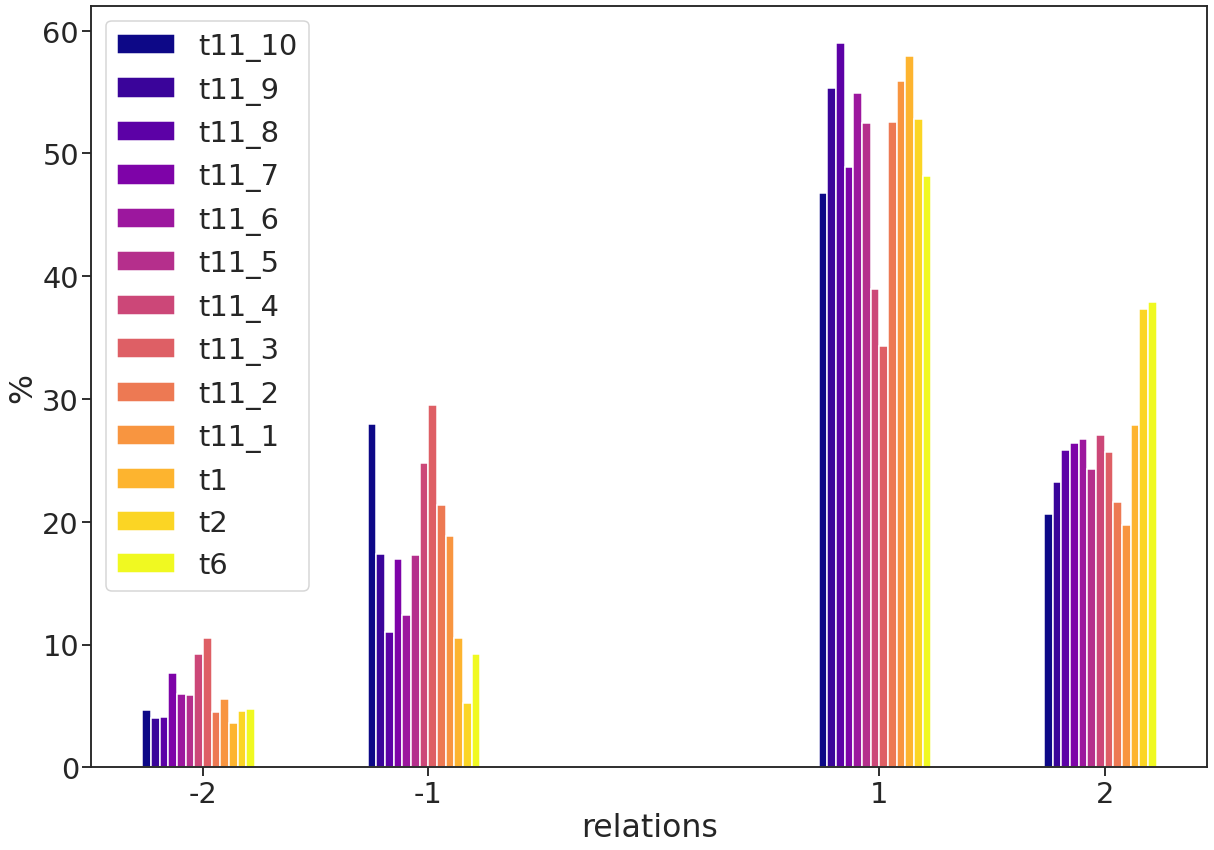

In [12]:


len_keys = len(dir_edges_all_dict.keys())
color = iter(plt.cm.plasma(np.linspace(0, 1, len_keys)))

bins_hist = np.array([-2,-1,0,1,2])

fig_relations = plt.figure(figsize = (20,14))
ind_pl = 0
num_bars = len(dir_edges_all_dict.keys())
width_pl = 1/(2*num_bars)
print('width_pl', width_pl)

for key_ind in dir_edges_all_dict.keys():
    labels_create_percentages = np.array([ aaa for aaa in np.array(dir_edges_all_dict[key_ind] )[:,2]])
    plot_hist = [100*np.shape(np.where(labels_create_percentages.flatten() == -2))[1]/np.shape(labels_create_percentages.flatten())[0], 100*np.shape(np.where(labels_create_percentages.flatten() == -1))[1]/np.shape(labels_create_percentages.flatten())[0],100*np.shape(np.where(labels_create_percentages.flatten() == 0))[1]/np.shape(labels_create_percentages.flatten())[0], 100*np.shape(np.where(labels_create_percentages.flatten() == 1))[1]/np.shape(labels_create_percentages.flatten())[0], 100*np.shape(np.where(labels_create_percentages.flatten() == 2))[1]/np.shape(labels_create_percentages.flatten())[0]]
    color_pl = next(color)
    plt.bar(bins_hist-num_bars/2*width_pl+width_pl*ind_pl, plot_hist, width = width_pl, label = key_ind, color = color_pl)
    ind_pl += 1

plt.ylabel('%')
plt.xlabel('relations')
plt.xticks([-2,-1,1,2], [-2,-1,1,2]) 
plt.legend()
plt.show()


Studying the prosociality of the students

width_pl 0.009615384615384616


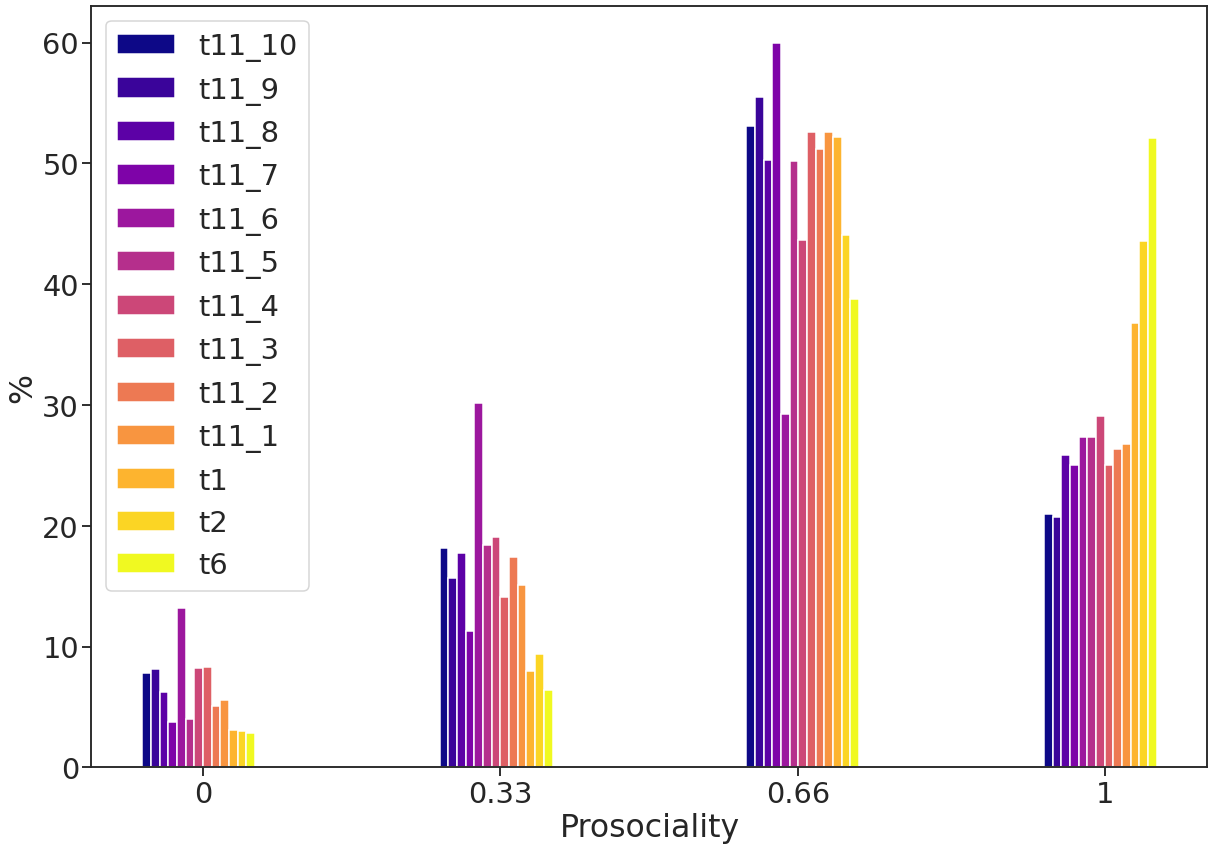

In [13]:

len_keys = len(dir_edges_all_dict.keys())
color = iter(plt.cm.plasma(np.linspace(0, 1, len_keys)))

fig_prosc = plt.figure(figsize = (20,14))
ind_pl = 0
num_bars = len(dir_edges_all_dict.keys())
width_pl = 1/(2*num_bars)/4
print('width_pl', width_pl)
bins_hist = np.array([0., 0.33, 0.67, 1.])

for key_ind in dir_edges_all_dict.keys():
    labels_create_percentages = np.array(prosocial_dict[key_ind])
      
    plot_hist = [100*np.shape(np.where(labels_create_percentages.flatten() == 0))[1]/np.shape(labels_create_percentages.flatten())[0], 100*np.shape(np.where(labels_create_percentages.flatten() == 0.33))[1]/np.shape(labels_create_percentages.flatten())[0],100*np.shape(np.where(labels_create_percentages.flatten() == 0.67))[1]/np.shape(labels_create_percentages.flatten())[0], 100*np.shape(np.where(labels_create_percentages.flatten() == 1))[1]/np.shape(labels_create_percentages.flatten())[0]]
    color_pl = next(color)
    plt.bar(bins_hist-num_bars/2*width_pl+width_pl*ind_pl, plot_hist, width = width_pl, label = key_ind, color = color_pl)
    ind_pl += 1


plt.xticks([0,0.33,0.66,1], [0,0.33,0.66,1]) #, rotation='vertical')

plt.ylabel('%')
plt.xlabel('Prosociality')
# plt.title('Prosociality in each school')
plt.legend()
plt.show()


# fig_prosc.savefig(GD_folder_figures+ '/Prosociality_each_school_new.pdf', bbox_inches='tight')


Create matrices with relationships between students

In [14]:

### MATRICES FOR ALL THE SCHOOLS MERGED ###

#weighted adjacency matrix
adj_matrix_relations = np.zeros((len(Student_Id_all_sort),len(Student_Id_all_sort)))

#asymmetric adjacency matrix (only ones if there is a directed relation)
adj_matrix_ones = np.zeros((len(Student_Id_all_sort),len(Student_Id_all_sort)))

all_edges = np.array(all_edges)

for iii in range(len(all_edges)):

    adj_matrix_relations[mapping_Ids[all_edges[iii,0]], mapping_Ids[all_edges[iii,1]]] = all_edges[iii,2]
    
    if all_edges[iii,2] != 0:
        adj_matrix_ones[mapping_Ids[all_edges[iii,0]], mapping_Ids[all_edges[iii,1]]] = 1

Studying the number of relationships between the different gender combinations

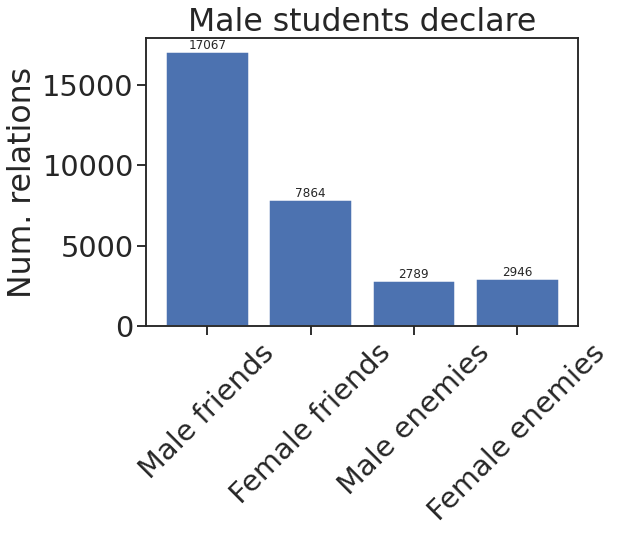

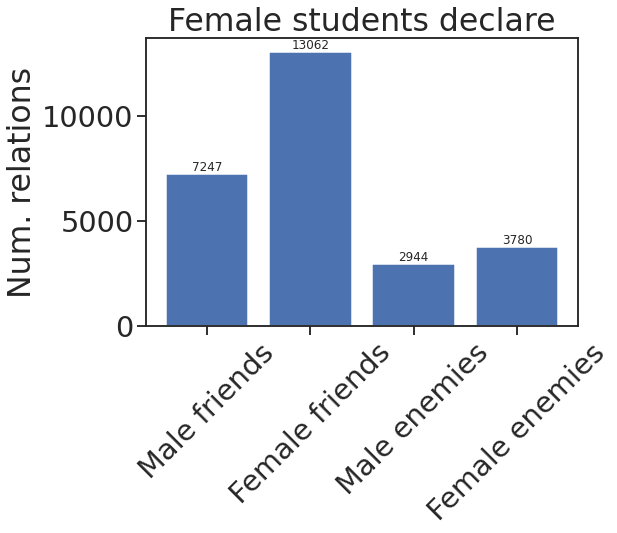

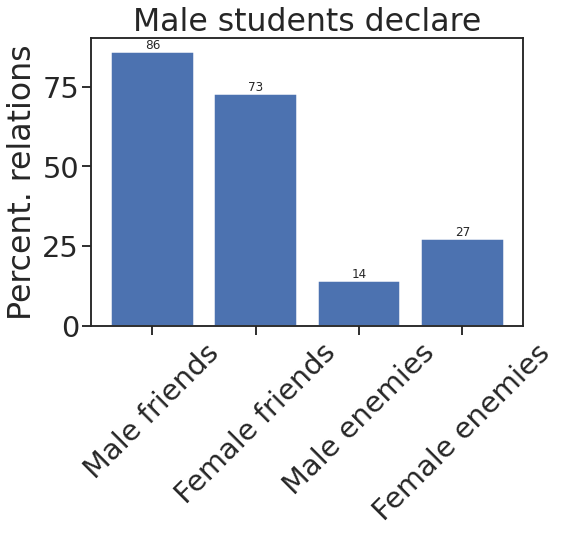

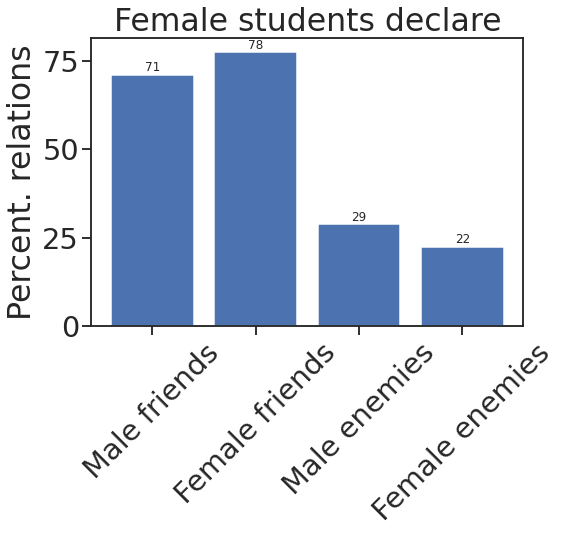

In [15]:
### Plotting proportion of male/female friend for male and female students

ind_males = np.where(np.array(Sexo_all_sort) == 1)[0]

total_num_male_friends_male_st = 0
total_num_female_friends_male_st = 0
total_num_male_enemies_male_st = 0
total_num_female_enemies_male_st = 0

for male_st in ind_males:
    friends_of_male_st = np.where(adj_matrix_relations[male_st,:] > 0)[0]
    gender_of_friends = [Sexo_all_sort[aaa] for aaa in friends_of_male_st]
    num_female_friends = gender_of_friends.count(0)
    num_male_friends = gender_of_friends.count(1)
    total_num_male_friends_male_st += num_male_friends
    total_num_female_friends_male_st += num_female_friends

    enemies_of_male_st = np.where(adj_matrix_relations[male_st,:] < 0)[0]
    gender_of_enemies = [Sexo_all_sort[aaa] for aaa in enemies_of_male_st]
    num_female_enemies = gender_of_enemies.count(0)
    num_male_enemies = gender_of_enemies.count(1)
    total_num_male_enemies_male_st += num_male_enemies
    total_num_female_enemies_male_st += num_female_enemies


ind_females = np.where(np.array(Sexo_all_sort) == 0)[0]

total_num_male_friends_female_st = 0
total_num_female_friends_female_st = 0
total_num_male_enemies_female_st = 0
total_num_female_enemies_female_st = 0

for female_st in ind_females:
    friends_of_female_st = np.where(adj_matrix_relations[female_st,:] > 0)[0]
    gender_of_friends = [Sexo_all_sort[aaa] for aaa in friends_of_female_st]
    num_female_friends = gender_of_friends.count(0)
    num_male_friends = gender_of_friends.count(1)
    total_num_male_friends_female_st += num_male_friends
    total_num_female_friends_female_st += num_female_friends

    enemies_of_female_st = np.where(adj_matrix_relations[female_st,:] < 0)[0]
    gender_of_enemies = [Sexo_all_sort[aaa] for aaa in enemies_of_female_st]
    num_female_enemies = gender_of_enemies.count(0)
    num_male_enemies = gender_of_enemies.count(1)
    total_num_male_enemies_female_st += num_male_enemies
    total_num_female_enemies_female_st += num_female_enemies


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Male friends', 'Female friends', 'Male enemies', 'Female enemies']
students = [total_num_male_friends_male_st,total_num_female_friends_male_st,total_num_male_enemies_male_st,total_num_female_enemies_male_st]
ax.bar(langs,students)

rects = ax.patches
for rect, label in zip(rects, students):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom", fontsize=12)

plt.title('Male students declare')
plt.ylabel('Num. relations')
plt.xticks(rotation = 45)
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Male friends', 'Female friends', 'Male enemies', 'Female enemies']
students = [total_num_male_friends_female_st,total_num_female_friends_female_st,total_num_male_enemies_female_st,total_num_female_enemies_female_st]
ax.bar(langs,students)
plt.title('Female students declare')
plt.xticks(rotation = 45)

rects = ax.patches
for rect, label in zip(rects, students):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom", fontsize=12)

plt.ylabel('Num. relations')
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Male friends', 'Female friends', 'Male enemies', 'Female enemies']

total_relations_with_male = total_num_male_friends_male_st + total_num_male_enemies_male_st
total_relations_with_female = total_num_female_friends_male_st + total_num_female_enemies_male_st

students = 100*np.array([total_num_male_friends_male_st/total_relations_with_male,total_num_female_friends_male_st/total_relations_with_female,total_num_male_enemies_male_st/total_relations_with_male,total_num_female_enemies_male_st/total_relations_with_female])
ax.bar(langs,students)

rects = ax.patches
for rect, label in zip(rects, students):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, round(label), ha="center", va="bottom", fontsize=12)

plt.title('Male students declare')
plt.ylabel('Percent. relations')
plt.xticks(rotation = 45)
plt.show()




fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Male friends', 'Female friends', 'Male enemies', 'Female enemies']
total_relations_with_male = total_num_male_friends_female_st + total_num_male_enemies_female_st
total_relations_with_female = total_num_female_friends_female_st + total_num_female_enemies_female_st

students = 100*np.array([total_num_male_friends_female_st/total_relations_with_male,total_num_female_friends_female_st/total_relations_with_female,total_num_male_enemies_female_st/total_relations_with_male,total_num_female_enemies_female_st/total_relations_with_female])


ax.bar(langs,students)
plt.title('Female students declare')
plt.xticks(rotation = 45)

rects = ax.patches
for rect, label in zip(rects, students):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, round(label), ha="center", va="bottom", fontsize=12)

plt.ylabel('Percent. relations')
plt.show()

Computing the triadic influence

In [16]:
## COMPUTING A MATRIX WITH INFORMATION ABOUT WHAT YOUR FIRST ORDER CONTACTS TELL YOU OF SOMEONE ELSE
friend_influence = np.dot(adj_matrix_relations,adj_matrix_relations)
np.fill_diagonal(friend_influence, 0.0) #remove the diagonal

## COMPUTING A MATRIX COUNTING THE NUMBER OF DIRECTED PATHS OF LENGTH 2 (IT IS NOT SYMMETRIC)
counting_first_contacts = np.dot(adj_matrix_ones,adj_matrix_ones)
np.fill_diagonal(counting_first_contacts, 0.0) #remove the diagonal

## Create a list with the number of directed paths of length 2 between the nodes forming each edge
list_num_contacts = []
for iii in range(len(all_edges)):
    list_num_contacts += [counting_first_contacts[mapping_Ids[all_edges[iii,0]], mapping_Ids[all_edges[iii,1]]] ]


Understanding if the prosociality of the student that recives or declares a relationship affects the sign of the relationship

In [ ]:

students_with_prosoc_col_3 = np.array(Student_Id_all_sort)
social_skills_col_3 = np.array(prosocial_all_sort)
all_relations_col_3 = np.zeros((len(students_with_prosoc_col_3),6))

for ind in range(len(students_with_prosoc_col_3)):

  relations_from_col_3 = np.where(all_edges[:,0]==students_with_prosoc_col_3[ind])[0]
  relations_values_col_3 = np.array([all_edges[aaa,2] for aaa in relations_from_col_3])
  #Number of people they consider their friends
  num_friends_from_col_3 = len(np.where(relations_values_col_3>0)[0])
  #Number of people they consider their enemies
  num_enemies_from_col_3 = len(np.where(relations_values_col_3<0)[0])

  relations_to_col_3 = np.where(all_edges[:,1]==students_with_prosoc_col_3[ind])[0]
  relations_values_col_3 = np.array([all_edges[aaa,2] for aaa in relations_to_col_3])
  #Number of people that consider them their friends
  num_friends_to_col_3 = len(np.where(relations_values_col_3>0)[0])
  #Number of people that consider them their enemies
  num_enemies_to_col_3 = len(np.where(relations_values_col_3<0)[0])

  all_relations_col_3[ind,0] = students_with_prosoc_col_3[ind]
  all_relations_col_3[ind,1] = social_skills_col_3[ind]
  all_relations_col_3[ind,2] = num_friends_from_col_3
  all_relations_col_3[ind,3] = num_enemies_from_col_3
  all_relations_col_3[ind,4] = num_friends_to_col_3
  all_relations_col_3[ind,5] = num_enemies_to_col_3


siz1 = 12
siz2 = 6
regul_div = 0.1 # regularizer for the division of friends over enemies

x_plot_col_3 = all_relations_col_3[:,1]
x_plot_u_col_3 = np.unique(x_plot_col_3)
y_plot_col_3 = all_relations_col_3[:,2]
y_pl_av_col_3 = []
y_pl_std_col_3 = []
for x_ind_col_3 in x_plot_u_col_3:
  inds_x_col_3 = np.where(x_plot_col_3==x_ind_col_3)[0]
  y_pl_av_col_3 += [np.mean([y_plot_col_3[aaa] for aaa in inds_x_col_3])]
  y_pl_std_col_3 += [np.std([y_plot_col_3[aaa] for aaa in inds_x_col_3])/np.sqrt(len(inds_x_col_3))]


fig, axs = plt.subplots(1, figsize=(siz1,siz2))
axs.errorbar(x_plot_u_col_3, y_pl_av_col_3, fmt='o', ls='None', yerr=y_pl_std_col_3, capsize=10)
axs.set_xlabel('Prosocial')
axs.set_ylabel('Number friends (from)')
plt.show()


x_plot_col_3 = all_relations_col_3[:,1]
x_plot_u_col_3 = np.unique(x_plot_col_3)
y_plot_col_3 = all_relations_col_3[:,3]
y_pl_av_col_3 = []
y_pl_std_col_3 = []
for x_ind_col_3 in x_plot_u_col_3:
  inds_x_col_3 = np.where(x_plot_col_3==x_ind_col_3)[0]
  y_pl_av_col_3 += [np.mean([y_plot_col_3[aaa] for aaa in inds_x_col_3])]
  y_pl_std_col_3 += [np.std([y_plot_col_3[aaa] for aaa in inds_x_col_3])/np.sqrt(len(inds_x_col_3))]


fig, axs = plt.subplots(1, figsize=(siz1,siz2))
axs.errorbar(x_plot_u_col_3, y_pl_av_col_3, fmt='o', ls='None', yerr=y_pl_std_col_3, capsize=10)
axs.set_xlabel('Prosocial')
axs.set_ylabel('Number enemies (from)')
plt.show()


x_plot_col_3 = all_relations_col_3[:,1]
x_plot_u_col_3 = np.unique(x_plot_col_3)
y_plot_col_3 = all_relations_col_3[:,4]
y_pl_av_col_3 = []
y_pl_std_col_3 = []
for x_ind_col_3 in x_plot_u_col_3:
  inds_x_col_3 = np.where(x_plot_col_3==x_ind_col_3)[0]
  y_pl_av_col_3 += [np.mean([y_plot_col_3[aaa] for aaa in inds_x_col_3])]
  y_pl_std_col_3 += [np.std([y_plot_col_3[aaa] for aaa in inds_x_col_3])/np.sqrt(len(inds_x_col_3))]

fig, axs = plt.subplots(1, figsize=(siz1,siz2))
axs.errorbar(x_plot_u_col_3, y_pl_av_col_3, fmt='o', ls='None', yerr=y_pl_std_col_3, capsize=10)
axs.set_xlabel('Prosocial')
axs.set_ylabel('Number friends (to)')
plt.show()


x_plot_col_3 = all_relations_col_3[:,1]
x_plot_u_col_3 = np.unique(x_plot_col_3)
y_plot_col_3 = all_relations_col_3[:,5]
y_pl_av_col_3 = []
y_pl_std_col_3 = []
for x_ind_col_3 in x_plot_u_col_3:
  inds_x_col_3 = np.where(x_plot_col_3==x_ind_col_3)[0]
  y_pl_av_col_3 += [np.mean([y_plot_col_3[aaa] for aaa in inds_x_col_3])]
  y_pl_std_col_3 += [np.std([y_plot_col_3[aaa] for aaa in inds_x_col_3])/np.sqrt(len(inds_x_col_3))]

fig, axs = plt.subplots(1, figsize=(siz1,siz2))
axs.errorbar(x_plot_u_col_3, y_pl_av_col_3, fmt='o', ls='None', yerr=y_pl_std_col_3, capsize=10)
axs.set_xlabel('Prosocial')
axs.set_ylabel('Number enemies (to)')
plt.show()



Percentage of relationships that connect two nodes that are also connected by a certain number of directed paths of length 2

In [ ]:

len_keys = len(dir_edges_all_dict.keys())
color = iter(plt.cm.plasma(np.linspace(0, 1, len_keys)))

fig_num_relations = plt.figure(figsize=(20,14))

bins_hist = [aaa for aaa in range(0,40,1)]

number_edges = []

x_violin = []
y_violin = []
key_vio = []
list_num_contacts_pl_vio = []

for key_ind in dir_edges_all_dict.keys():
    
    edges_pl = np.array(dir_edges_all_dict[key_ind])

    list_num_contacts_pl = []
    for iii in range(len(edges_pl)):
        list_num_contacts_pl += [counting_first_contacts[mapping_Ids[edges_pl[iii,0]], mapping_Ids[edges_pl[iii,1]]] ]

    color_pl = next(color)

    bin_vio = plt.hist(list_num_contacts_pl, bins=bins_hist,  density=True, histtype=u'step', label =  key_ind, color = color_pl)
    
    x_violin += [bin_vio[0]]
    y_violin += [bin_vio[1]]
    list_num_contacts_pl_vio += [list_num_contacts_pl]
    
    key_vio += [key_ind]

    number_edges += [len(list_num_contacts_pl)]

plt.hist(list_num_contacts, bins=bins_hist,  density=True, histtype=u'step', linewidth=2.5 , color= 'k')

plt.ylabel('% of relations')
plt.xlabel('#  paths of length 2 '+ r'$\left( \sum_k  A_{ik}A_{kj} \right)$')
plt.legend()
plt.show()



y_total = []
x_total = []
for iii in range(len(list_num_contacts_pl_vio)):
    y_total += list_num_contacts_pl_vio[iii]
    x_total += [key_vio[iii]] * len(list_num_contacts_pl_vio[iii])


fig_vio = plt.figure(figsize=(26,12))
sns.violinplot(y=y_total, x=x_total ,  palette = [aaa for aaa in plt.cm.plasma(np.linspace(0, 1, len_keys))])#,  palette=['tomato', 'cornflowerblue']) #palette=plt.cm.plasma(np.linspace(0, 1, len_keys))#
plt.ylabel('#  paths of length 2 '+ r'$\left( \sum_k  A_{ik}A_{kj} \right)$')
plt.xlabel('Schools')
plt.show()




# Training the Neural Network (NN)

Defining the NN

In [ ]:

Softmax_com = torch.nn.Softmax(dim=1)

class Net_4(nn.Module):

    # NN definition
    def __init__(self,train_with, add_friend_influence,seed,nn_input_dim,nn_width,nn_output_dim):
        super(Net_4, self).__init__()

        torch.manual_seed(seed)

        self.ly1 = nn.Linear(nn_input_dim, nn_width)  
        self.ly2 = nn.Linear(nn_width, nn_width)
        self.ly3 = nn.Linear(nn_width, nn_output_dim)
        self.train_with = train_with
        self.add_friend_influence = add_friend_influence

    def forward(self, x, linear = False):
        x = self.training_attributes_2(x)
        x = self.ly1(x)
        if not linear:
            x = F.relu(x)
        x = self.ly3(x)
        return x 
    
    # some funtions that we will use to plot the predictions
    def input_skills_no_inf(self,X,Y):
        x = torch.FloatTensor([[X[aaa],Y[aaa]] for aaa in range(X.shape[0])])
        x = self.ly1(x)
        x = F.relu(x)
        x = self.ly3(x)
        return Softmax_com(x)
        
    def input_skills_only_inf(self,X):
        x = torch.FloatTensor([[X[aaa]] for aaa in range(X.shape[0])])
        x = self.ly1(x)
        x = F.relu(x)
        x = self.ly3(x)
        return Softmax_com(x) 
      
    # Merging the information about the students that we will use to predict relationships   
    def training_attributes_2(self, x):

        attributes = []

        if 'prosocial' in self.train_with:
            attributes = np.array([[prosocial_sort[x[aaa,0]],prosocial_sort[x[aaa,1]]] for aaa in range(x.shape[0])])

        if 'CRT' in self.train_with:
            if len(attributes) == 0:
                attributes = np.array([[CRT_sort[x[aaa,0]],CRT_sort[x[aaa,1]]] for aaa in range(x.shape[0])])
            else:
                attributes = np.hstack((attributes,np.array([[CRT_sort[x[aaa,0]],CRT_sort[x[aaa,1]]] for aaa in range(x.shape[0])])))

        if 'Sexo' in self.train_with:
            if len(attributes) == 0:
                attributes = np.array([[Sexo_sort[x[aaa,0]],Sexo_sort[x[aaa,1]]] for aaa in range(x.shape[0])])
            else:
                attributes = np.hstack((attributes,np.array([[Sexo_sort[x[aaa,0]],Sexo_sort[x[aaa,1]]] for aaa in range(x.shape[0])])))

        if self.add_friend_influence:
            if len(attributes) == 0:
                attributes = np.array([[friend_influence_torch[x[aaa,0],x[aaa,1]]] for aaa in range(x.shape[0])])
            else:
                attributes = np.hstack((attributes,np.array([[friend_influence_torch[x[aaa,0],x[aaa,1]]] for aaa in range(x.shape[0])])))

        return torch.FloatTensor(attributes) 

Defining some functions used during training

In [ ]:

#computing the accuracy of the model
def calc_accuracy(mdl,X,Y):
    max_vals, max_indices = torch.max(mdl(X),1)
    train_acc = (max_indices == Y).sum().data.numpy()/max_indices.size()[0]
    return train_acc

#computing the weighted (balanced) accuracy of the model
def calc_accuracy_weighted(mdl,X,Y):
    max_vals, max_indices = torch.max(mdl(X),1)
    classes_l = np.unique(Y)

    t_or_f = (max_indices == Y)
    acc=0
    for ii in classes_l:
        ind_c = np.where(Y==ii)[0]
        acc_1 = np.array([t_or_f[aaa] for aaa in ind_c]).sum()/len(ind_c)
        acc += acc_1
    acc = acc/len(classes_l)
    return acc

# Only used if considering dynamical loss functions (http://proceedings.mlr.press/v139/ruiz-garcia21a/ruiz-garcia21a.pdf) 
# this function creates the oscillations in the dynamical loss function
def c_fn(t, i, w_max, T, C):
    slope = 2 * (w_max - 1) / T
    w_main_class = np.where(t < T / 2., 1 + t * slope, 2 * w_max - t * slope - 1)
    res = np.ones(C) + (w_main_class - 1) * np.eye(C)[i]
    res = res / np.sum(res) * C
    return torch.tensor(res, dtype=torch.float)


#plotting the probabilities learnt by the NN
titles = ['Probability Enemies','Probability Friends']
def plot_probabilities_2(net_1,axs_1,fig,train_with):
  
  number_points_grid = 25
  x = np.linspace(0, 1, number_points_grid)
  y = np.linspace(0, 1, number_points_grid)
  X, Y = np.meshgrid(x, y)

  Z = net_1.input_skills_no_inf(X.flatten(), Y.flatten()).detach().numpy()
  
  Z = Z.reshape(number_points_grid,number_points_grid,Z.shape[1])

  for ind_prob in range(0,Z.shape[2]):
      max_val = np.max(Z[:,:,ind_prob])
      min_val = np.min(Z[:,:,ind_prob])
      im = axs_1[ind_prob].contourf(X, Y, Z[:,:,ind_prob], 30, cmap='plasma' )# **kw) # , vmin=0.1, vmax=0.4) #RdGy
      axs_1[ind_prob].set_xlabel(train_with[0] + ' (from)')
      axs_1[ind_prob].set_ylabel(train_with[0] + ' (to)')
      axs_1[ind_prob].set_title(titles[ind_prob])

      divider = make_axes_locatable(axs_1[ind_prob])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      cbar = fig.colorbar(im, cax=cax, orientation='vertical')
      cbar.set_ticks([])
      cax.text(0.15, 1.01, str(round(max_val,2)), transform=cax.transAxes)
      cax.text(0.15, -0.02, str(round(min_val,2)), transform=cax.transAxes)
    

Training the NN

In [ ]:
def train_NN_new(x_two_cl_train_torch, y_two_cl_train_torch, x_two_cl_test_torch, y_two_cl_test_torch, train_with = [ ], add_friend_influence = True, proportion_train_test = 1, n_epochs = 100, w_max_osc =  1, num_periods = 40,learning_rate = 0.1, gamma_LR = 0.99, Linear_TF = False, num_minibatches = 2, batch_size = 20):
    
    # w_max_osc =  1 corresponds to the standard cross entropy loss (no dynamical loss function)
    
    D_folder_results = '.'
    x_two_cl_train = x_two_cl_train_torch.detach().numpy()
    y_two_cl_train = y_two_cl_train_torch.detach().numpy()
    x_two_cl_test = x_two_cl_test_torch.detach().numpy()
    y_two_cl_test = y_two_cl_test_torch.detach().numpy()

    node_feature_dim = len(train_with)

    if add_friend_influence:
      nn_input_dim = 2*node_feature_dim +1
    else:
      nn_input_dim = 2*node_feature_dim 

    nn_width = 100
    nn_output_dim = 2
    total_time_steps = n_epochs*num_minibatches 
    period_osc = total_time_steps/num_periods
    no_osc_last_epochs = 4
    snapshot_every = 10
    number_points_grid = 40

    seed_list = range(1)

    print('n_epochs',n_epochs,'total_time_steps',total_time_steps,'period_osc',period_osc, 'batch_size', batch_size)

    parameters = {'nn_width': nn_width,
                  'nn_input_dim': nn_input_dim,
                  'nn_output_dim': nn_output_dim,
                  'learning_rate': learning_rate,
                  'n_epochs': n_epochs,
                  'batch_size': batch_size,
                  'snapshot_every':snapshot_every,
                  'number_points_grid':number_points_grid,
                  'gamma_LR':gamma_LR,
                  'add_friend_influence':add_friend_influence}

    now = datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y_%H_%M_%S")

    with open(GD_folder_results + '/'+date_time+'_parameters.pkl', 'wb') as handle:
        pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

    trained_nets = []
    loss_list = []
    loss_list_test = []
    loss_save_uw_list = []
    w_max_osc_save = w_max_osc

    ind_enemies = np.array(np.where(y_two_cl_train == 0)[0])
    ind_friends = np.array(np.where(y_two_cl_train == 1)[0]) 

    print('starting simulation', 'np.shape(loss_list)',np.shape(loss_list),'np.shape(loss_list_test)',np.shape(loss_list_test))

    for seed_ind in seed_list:

        print('NEW SIMULATION. SEED: ', seed_ind)

        net = Net_4(train_with, add_friend_influence, seed_ind,nn_input_dim,nn_width,nn_output_dim)

        print('NN initialized ')

        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) #, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma_LR)

        loss_save = []
        loss_test_save = []
        loss_save_uw = []
        tr_accuracy_save = []
        test_accuracy_save = []
        tr_accuracy_save_w = []
        test_accuracy_save_w = []


        fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(42,6))
      
        titles = ['Probaility Enemies','Probaility Dislike','Probaility Indiferent','Probaility Like','Probaility Friends']

        tt = 0
        ii = 0
        cc = 0
        w_max_osc = w_max_osc_save

        for epoch in range(n_epochs):

            for i in range(num_minibatches):

                ## half the batch for each class
                x_ene = [x_two_cl_train[iii] for iii in np.random.choice(ind_enemies, size=int(batch_size/2))]
                x_fr =  [x_two_cl_train[iii] for iii in np.random.choice(ind_friends, size=int(batch_size/2))]

                y_ene = [y_two_cl_train[iii] for iii in np.random.choice(ind_enemies, size=int(batch_size/2))]
                y_fr =  [y_two_cl_train[iii] for iii in np.random.choice(ind_friends, size=int(batch_size/2))]

                batch_x, batch_y = torch.tensor(x_ene+x_fr, dtype=torch.int32) , torch.tensor(y_ene+y_fr, dtype=torch.long)

                optimizer.zero_grad()
                outputs = net.forward(batch_x, linear = Linear_TF)

                if tt > period_osc:

                    tt = 0
                    cc = (cc + 1) % nn_output_dim

                    print('New Period. Focus on class: ', cc)

                    if no_osc_last_epochs:

                        if ii > total_time_steps - no_osc_last_epochs*period_osc:
                            print('last period without oscillations')
                            w_max_osc = 1
                
                lossfunction = nn.CrossEntropyLoss(weight=c_fn(tt, cc, w_max_osc, period_osc, nn_output_dim)) # if w_max_osc =  1 -> no weighting
                loss = lossfunction(outputs,batch_y)
                loss.backward()
                optimizer.step()

                tt += 1
                ii += 1

            scheduler.step()

            tr_accuracy_w = calc_accuracy_weighted(net,x_two_cl_train_torch,y_two_cl_train_torch)
            tr_accuracy = calc_accuracy(net,x_two_cl_train_torch,y_two_cl_train_torch)

            outputs = net.forward(x_two_cl_train_torch)
            loss_forsaving = lossfunction(outputs,y_two_cl_train_torch)

            lossfunction_uw = nn.CrossEntropyLoss()
            loss_forsaving_uw = lossfunction_uw(outputs,y_two_cl_train_torch)

            loss_save += [loss_forsaving.detach().numpy()]
            loss_save_uw += [loss_forsaving_uw.detach().numpy()]

            tr_accuracy_save += [tr_accuracy]
            tr_accuracy_save_w += [tr_accuracy_w]

            if proportion_train_test != 1:
                test_accuracy_w = calc_accuracy_weighted(net,x_two_cl_test_torch,y_two_cl_test_torch)
                test_accuracy = calc_accuracy(net,x_two_cl_test_torch,y_two_cl_test_torch)
                outputs_test = net.forward(x_two_cl_test_torch)
                loss_forsaving_test = lossfunction(outputs_test,y_two_cl_test_torch)
                loss_test_save += [loss_forsaving_test.detach().numpy()]
                test_accuracy_save += [test_accuracy]
                test_accuracy_save_w += [test_accuracy_w]


            if tt % 10==0:
                print('epoch', epoch, 'LR', optimizer.param_groups[0]['lr'], 'loss', loss_forsaving_uw, 'training  acc: ', tr_accuracy)

        plt.figure()
        plt.plot(loss_save)
        plt.plot(loss_test_save)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        ax = plt.gca()
        ax.set_yscale('log')
        plt.show()

        plt.figure()
        plt.plot(tr_accuracy_save)
        plt.plot(test_accuracy_save)
        plt.xlabel('epochs')
        plt.ylabel('Accuracies')
        plt.show()

        plt.figure()
        plt.plot(tr_accuracy_save_w)
        plt.plot(test_accuracy_save_w)
        plt.xlabel('epochs')
        plt.ylabel('Weighted Accuracies')
        plt.show()

        trained_nets += [net]

        print('before saving', 'np.shape(loss_list)',np.shape(loss_list),'np.shape(loss_test_save)',np.shape(loss_test_save))

        loss_list += [loss_save]
        loss_list_test += [loss_test_save]
        loss_save_uw_list += [loss_save_uw]

        print('after saving', 'np.shape(loss_list)',np.shape(loss_list),'np.shape(loss_list_test)',np.shape(loss_list_test))

        if len(train_with)==1 and add_friend_influence == False:

            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
            plot_probabilities_2(net,axs,fig,train_with)
            plt.show()

            date_time = now.strftime("%m_%d_%Y_%H_%M_%S")
            fig.savefig(GD_folder_figures+ '/' + date_time + '_prob_friend_enemies_prosocial.pdf', bbox_inches='tight')

    return tr_accuracy_save, tr_accuracy_save_w, test_accuracy_save, test_accuracy_save_w, net

### Preparing the data 

Separating relationships that connect two students with a number of directed paths of length 2 between them below/above a certain threshold (we will use threshold=1). Therefore we separate the relationships which nodes are not connected by directed paths of length 2 from the rest.

In [ ]:

def separating_data_weak_strong(threshold_connection,proportion_train_test_weak,proportion_train_test_strong,data_edges_f,mapping_Ids,counting_first_contacts):
    
    x_data_strong_connection = []
    y_data_strong_connection = []

    x_data_weak_connection = []
    y_data_weak_connection = []

    for iii in range(len(data_edges_f)):

        student_from = data_edges_f[iii,0]
        student_to = data_edges_f[iii,1]
        weight_s = data_edges_f[iii,2]
      
        if counting_first_contacts[mapping_Ids[student_from], mapping_Ids[student_to]] < threshold_connection:
          
          x_data_weak_connection += [[mapping_Ids[student_from],mapping_Ids[student_to]]]
          y_data_weak_connection += [[weight_s+2]]

        else:

          x_data_strong_connection += [[mapping_Ids[student_from],mapping_Ids[student_to]]]
          y_data_strong_connection += [[weight_s+2]]
    
    print('np.shape(x_data_weak_connection)',np.shape(x_data_weak_connection))
    print('np.shape(y_data_weak_connection)',np.shape(y_data_weak_connection))
    print('np.shape(x_data_strong_connection)',np.shape(x_data_strong_connection))
    print('np.shape(y_data_strong_connection)',np.shape(y_data_strong_connection))    

    ### NUMBER OF EDGES OF EACH CLASS WEAK CONNECTION###
    x_data_weak_connection = np.array(x_data_weak_connection)
    y_data_weak_connection = np.array(y_data_weak_connection)
    x_data_strong_connection = np.array(x_data_strong_connection)
    y_data_strong_connection = np.array(y_data_strong_connection)

    if threshold_connection >= 1:

        print('\n weak connection')
        print(' Enemy edges: ', 100*np.shape(np.where(y_data_weak_connection.flatten() == 0))[1]/np.shape(y_data_weak_connection.flatten())[0],'%')
        print(' Dislike edges: ', 100*np.shape(np.where(y_data_weak_connection.flatten() == 1))[1]/np.shape(y_data_weak_connection.flatten())[0],'%')
        print(' Indiferent edges: ', 100*np.shape(np.where(y_data_weak_connection.flatten() == 2))[1]/np.shape(y_data_weak_connection.flatten())[0],'%')
        print(' Like edges: ', 100*np.shape(np.where(y_data_weak_connection.flatten() == 3))[1]/np.shape(y_data_weak_connection.flatten())[0],'%')
        print(' Friends edges: ', 100*np.shape(np.where(y_data_weak_connection.flatten() == 4))[1]/np.shape(y_data_weak_connection.flatten())[0],'%')


        num_edges_data = np.shape(y_data_weak_connection)[0]

        data_inds = random.sample(range(num_edges_data), num_edges_data)
        data_inds_train = data_inds[0:int(proportion_train_test_weak*num_edges_data)]
        data_inds_test = data_inds[int(proportion_train_test_weak*num_edges_data):]

        x_data_weak_connection_train = x_data_weak_connection[data_inds_train,:]
        x_data_weak_connection_test = x_data_weak_connection[data_inds_test,:]

        y_data_weak_connection_train = y_data_weak_connection[data_inds_train]
        y_data_weak_connection_test = y_data_weak_connection[data_inds_test]

        x_data_weak_connection_train = torch.tensor(x_data_weak_connection_train, dtype=torch.int32)
        x_data_weak_connection_test = torch.tensor(x_data_weak_connection_test, dtype=torch.int32)

        y_data_weak_connection_train = torch.tensor(y_data_weak_connection_train.flatten(), dtype=torch.long)
        y_data_weak_connection_test = torch.tensor(y_data_weak_connection_test.flatten(), dtype=torch.long)

    print('\n strong connection')
    print(' Enemy edges: ', 100*np.shape(np.where(y_data_strong_connection.flatten() == 0))[1]/np.shape(y_data_strong_connection.flatten())[0],'%')
    print(' Dislike edges: ', 100*np.shape(np.where(y_data_strong_connection.flatten() == 1))[1]/np.shape(y_data_strong_connection.flatten())[0],'%')
    print(' Indiferent edges: ', 100*np.shape(np.where(y_data_strong_connection.flatten() == 2))[1]/np.shape(y_data_strong_connection.flatten())[0],'%')
    print(' Like edges: ', 100*np.shape(np.where(y_data_strong_connection.flatten() == 3))[1]/np.shape(y_data_strong_connection.flatten())[0],'%')
    print(' Friends edges: ', 100*np.shape(np.where(y_data_strong_connection.flatten() == 4))[1]/np.shape(y_data_strong_connection.flatten())[0],'%')

    num_edges_data = np.shape(y_data_strong_connection)[0]
    data_inds = random.sample(range(num_edges_data), num_edges_data)
    data_inds_train = data_inds[0:int(proportion_train_test_strong*num_edges_data)]
    data_inds_test = data_inds[int(proportion_train_test_strong*num_edges_data):]

    x_data_strong_connection_train = x_data_strong_connection[data_inds_train,:]
    x_data_strong_connection_test = x_data_strong_connection[data_inds_test,:]

    y_data_strong_connection_train = y_data_strong_connection[data_inds_train]
    y_data_strong_connection_test = y_data_strong_connection[data_inds_test]

    x_data_strong_connection_train = torch.tensor(x_data_strong_connection_train, dtype=torch.int32)
    x_data_strong_connection_test = torch.tensor(x_data_strong_connection_test, dtype=torch.int32)

    y_data_strong_connection_train = torch.tensor(y_data_strong_connection_train.flatten(), dtype=torch.long)
    y_data_strong_connection_test = torch.tensor(y_data_strong_connection_test.flatten(), dtype=torch.long)


    if threshold_connection < 1:
        return x_data_strong_connection_train,y_data_strong_connection_train,x_data_strong_connection_test,y_data_strong_connection_test
    else:
        return x_data_strong_connection_train,y_data_strong_connection_train,x_data_strong_connection_test,y_data_strong_connection_test,x_data_weak_connection_train,y_data_weak_connection_train,x_data_weak_connection_test,y_data_weak_connection_test


Training only with two classes of links: label 2 and labels {-1,-2}. For convenience these labels correspond now to 4 and {0,1}. Oversampling the smaller class, same number of samples from each class in each minibatch


In [ ]:
def separate_two_classes(x_data_train_zeros,y_data_train_zeros,x_data_test_zeros,y_data_test_zeros):
      
    x_all = x_data_train_zeros.detach().numpy()
    print('np.shape(x_all)',np.shape(x_all))

    y_all = y_data_train_zeros.detach().numpy()

    ind_new_1 = list(np.where(y_all < 2)[0]) 
    ind_new_2 = list(np.where(y_all == 4)[0])

    x_enemies = [x_all[iii] for iii in ind_new_1]
    x_friends = [x_all[iii] for iii in ind_new_2]
    y_enemies = [0 for iii in ind_new_1] 
    y_friends = [1 for iii in ind_new_2] 

    x_two_cl_train = np.array(x_enemies+x_friends)
    y_two_cl_train = np.array(y_enemies+y_friends)

    ind_enemies = np.array(np.where(y_two_cl_train == 0)[0])
    ind_friends = np.array(np.where(y_two_cl_train == 1)[0]) 

    x_two_cl_train_torch = torch.tensor(x_two_cl_train, dtype=torch.int32)
    y_two_cl_train_torch = torch.tensor(y_two_cl_train, dtype=torch.long)


    x_all_test = x_data_test_zeros.detach().numpy()
    y_all_test = y_data_test_zeros.detach().numpy()

    ind_new_1_2 = list(np.where(y_all_test < 2)[0]) 
    ind_new_2_2 = list(np.where(y_all_test == 4)[0])

    x_enemies_2 = [x_all_test[iii] for iii in ind_new_1_2]
    x_friends_2 = [x_all_test[iii] for iii in ind_new_2_2]
    y_enemies_2 = [0 for iii in ind_new_1_2] 
    y_friends_2 = [1 for iii in ind_new_2_2] 

    x_two_cl_test = np.array(x_enemies_2+x_friends_2)
    y_two_cl_test = np.array(y_enemies_2+y_friends_2)

    x_two_cl_test_torch = torch.tensor(x_two_cl_test, dtype=torch.int32)
    y_two_cl_test_torch = torch.tensor(y_two_cl_test, dtype=torch.long)

    return x_two_cl_train_torch, y_two_cl_train_torch, x_two_cl_test_torch, y_two_cl_test_torch


Creating the datasets for training

In [ ]:

threshold_connection = 1 

proportion_train_test_weak = 1 #(not enough data to do validation)
proportion_train_test_strong = 0.8

x_data_strong_connection_train_col_3,y_data_strong_connection_train_col_3,x_data_strong_connection_test_col_3,y_data_strong_connection_test_col_3,x_data_weak_connection_train_col_3,y_data_weak_connection_train_col_3,x_data_weak_connection_test_col_3,y_data_weak_connection_test_col_3 = separating_data_weak_strong(threshold_connection,proportion_train_test_weak,proportion_train_test_strong,all_edges,mapping_Ids,counting_first_contacts)

print('\n strong connection' )
x_two_cl_train_torch_strong_col_3, y_two_cl_train_torch_strong_col_3, x_two_cl_test_torch_strong_col_3, y_two_cl_test_torch_strong_col_3 = separate_two_classes(x_data_strong_connection_train_col_3,y_data_strong_connection_train_col_3,x_data_strong_connection_test_col_3,y_data_strong_connection_test_col_3)

print('\n weak connection' )
x_two_cl_train_torch_weak_col_3, y_two_cl_train_torch_weak_col_3, x_two_cl_test_torch_weak_col_3, y_two_cl_test_torch_weak_col_3 = separate_two_classes(x_data_weak_connection_train_col_3,y_data_weak_connection_train_col_3,x_data_weak_connection_test_col_3,y_data_weak_connection_test_col_3)

In [ ]:
friend_influence_torch = torch.tensor(friend_influence, dtype=torch.float)
prosocial_sort = prosocial_all_sort
CRT_sort = crttotal_all_sort
Sexo_sort = Sexo_all_sort

Training the NN using only the triadic influence between the students. We train 10 NN from scratch, we will average the results below.

n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 


<ipython-input-21-b8eb14ec3e7b>:98: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  batch_x, batch_y = torch.tensor(x_ene+x_fr, dtype=torch.int32) , torch.tensor(y_ene+y_fr, dtype=torch.long)


New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
last period without oscillations
New Pe

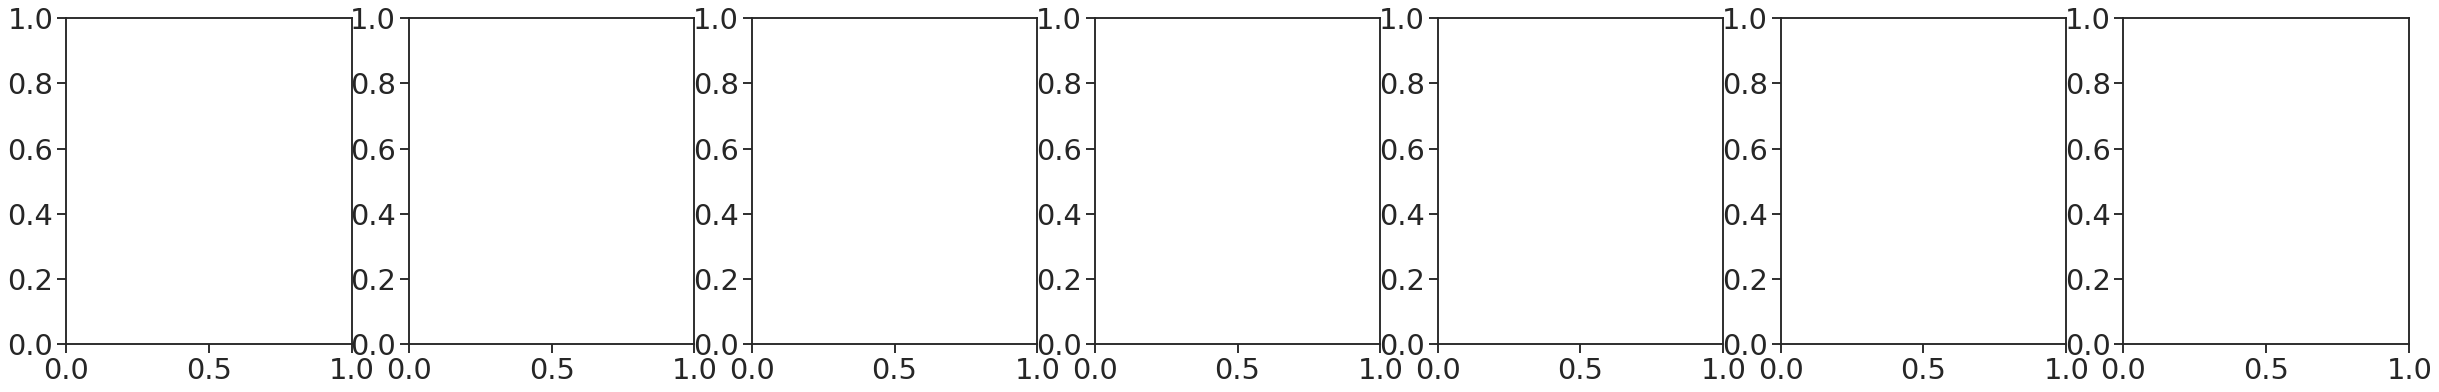

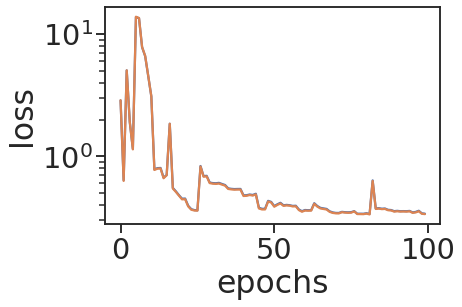

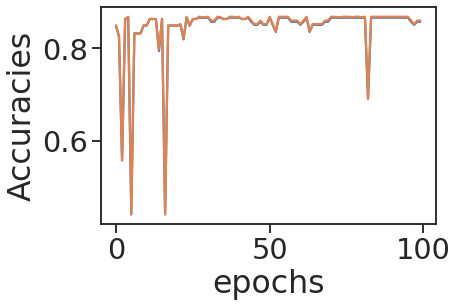

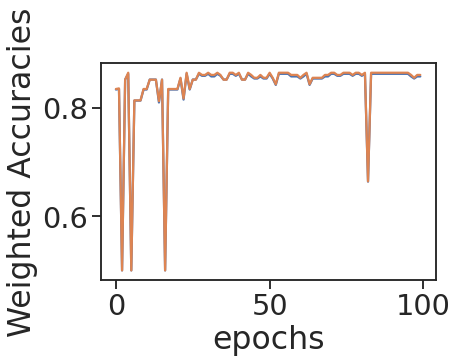

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

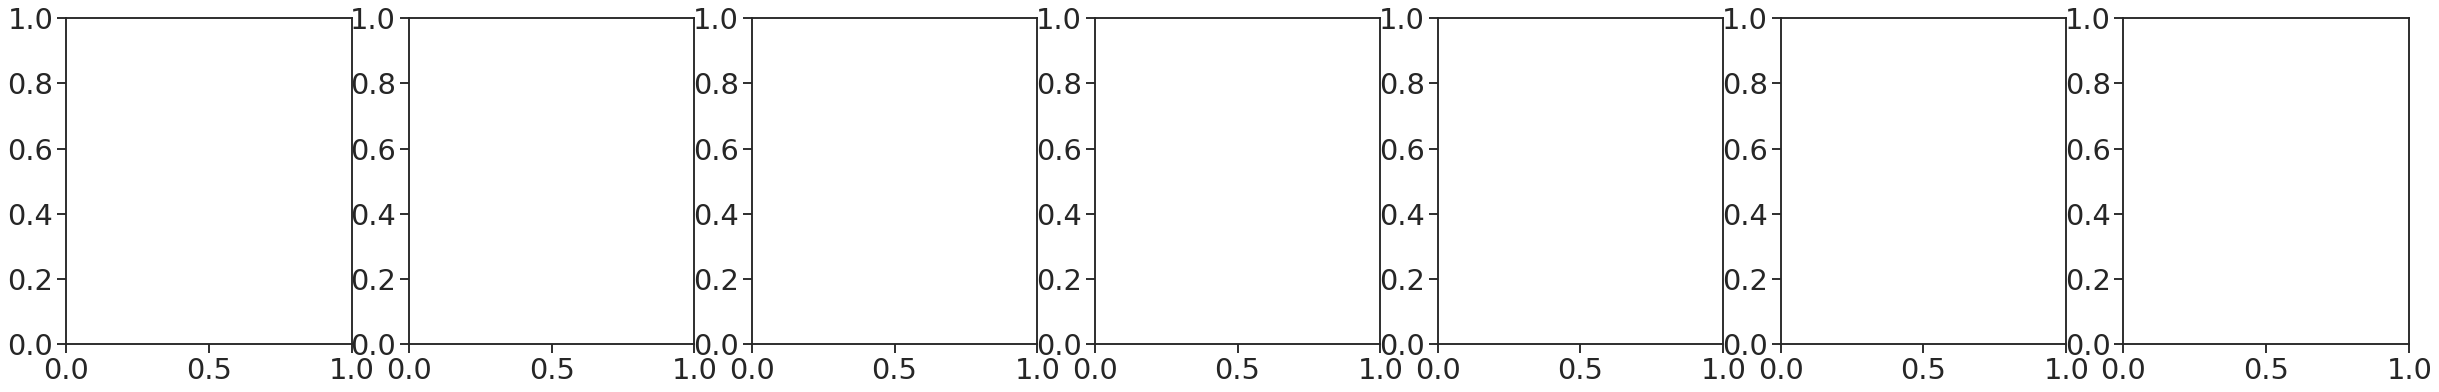

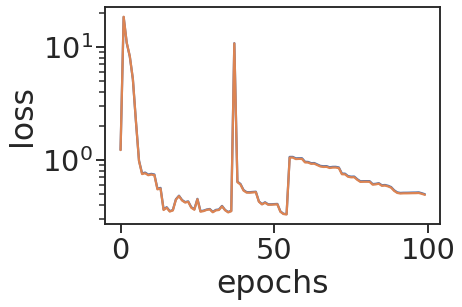

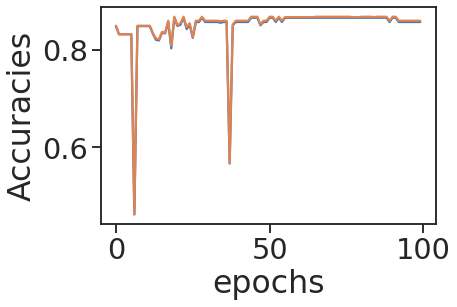

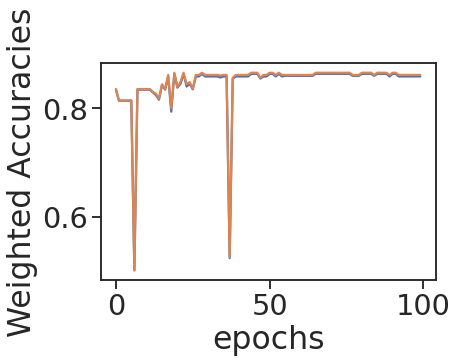

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

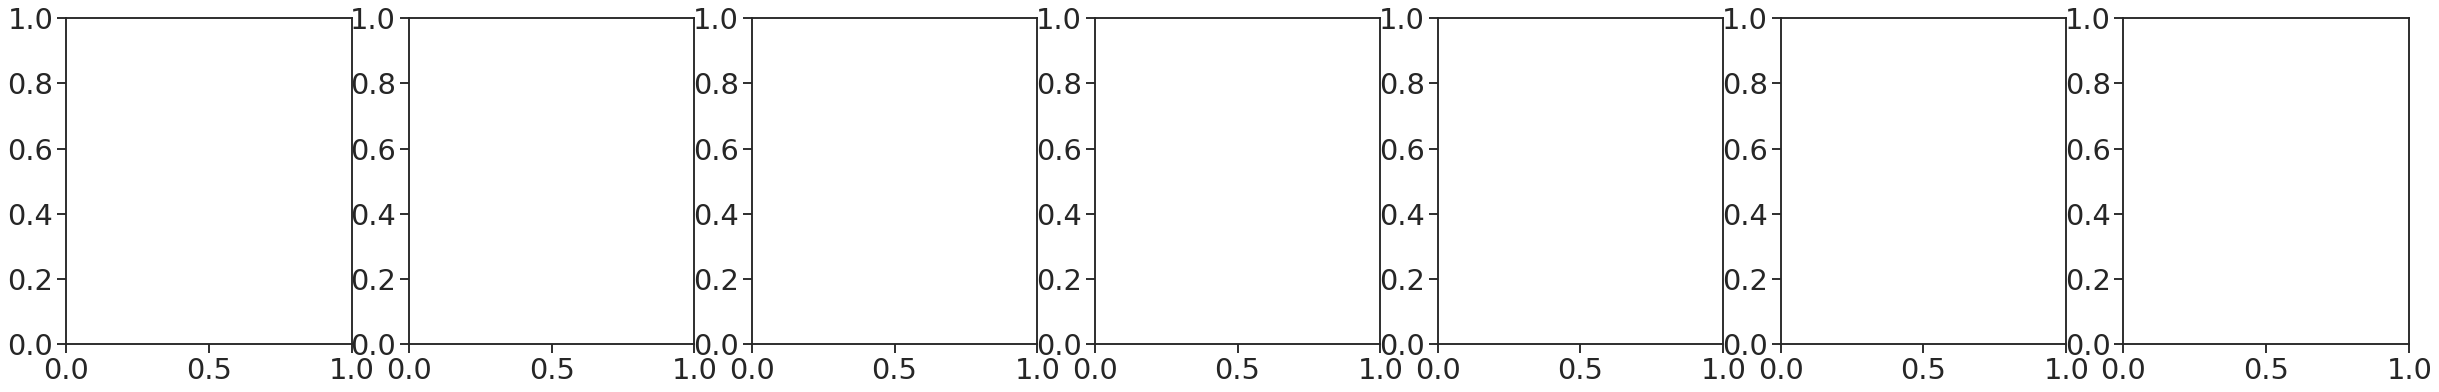

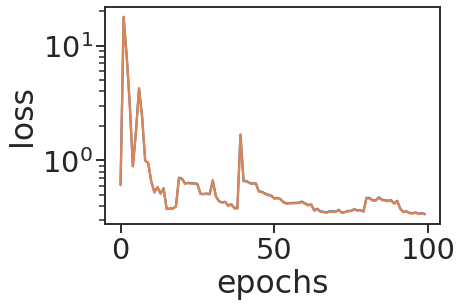

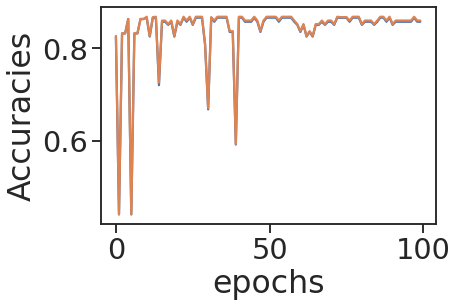

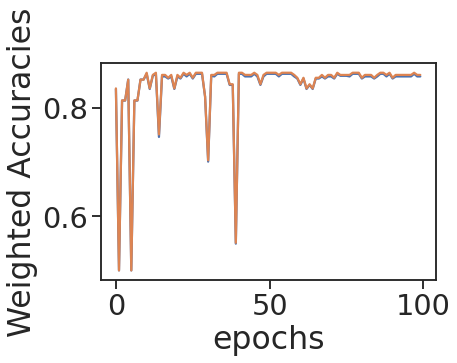

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

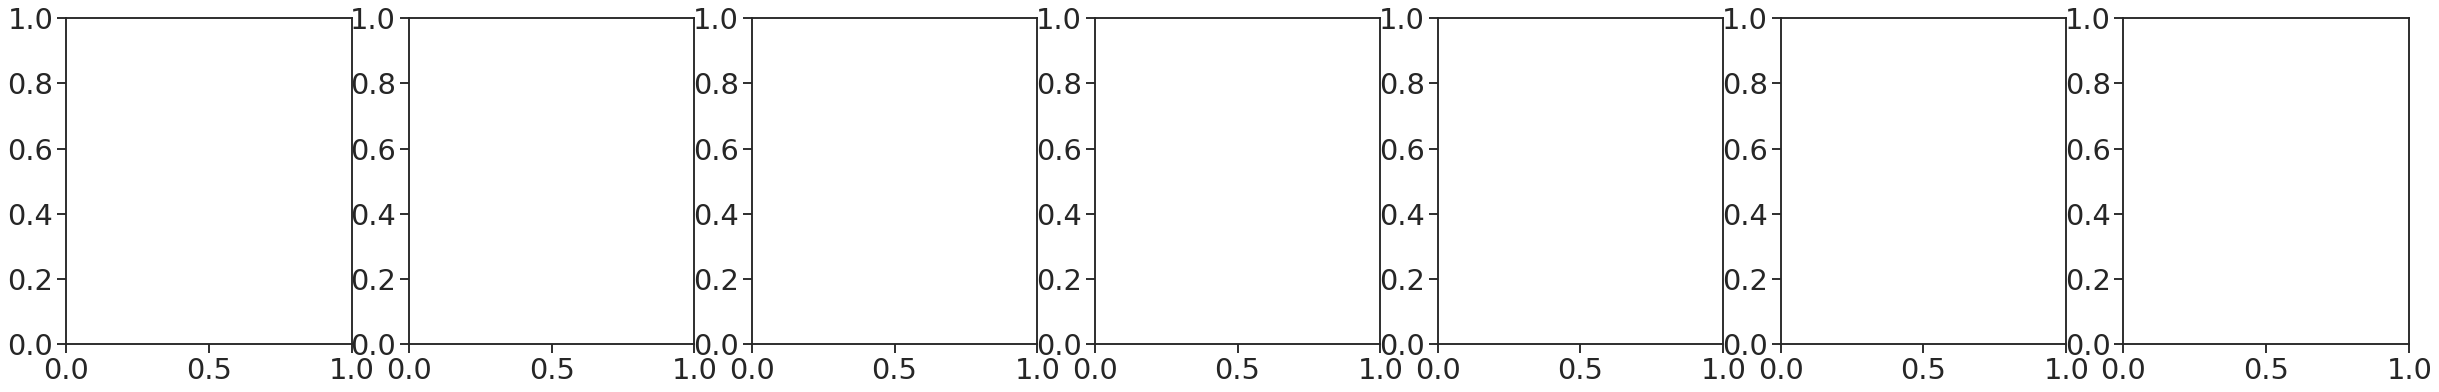

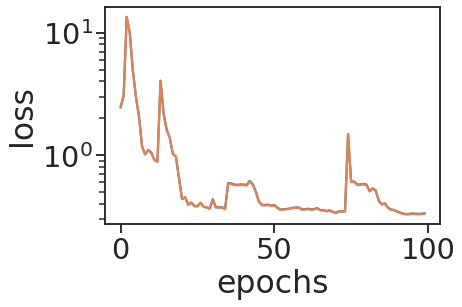

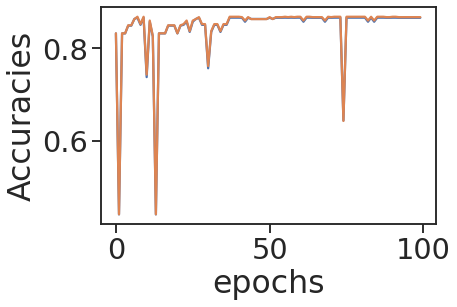

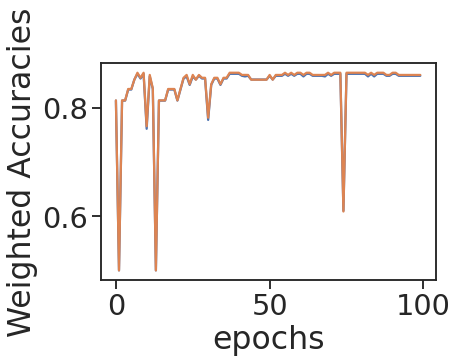

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

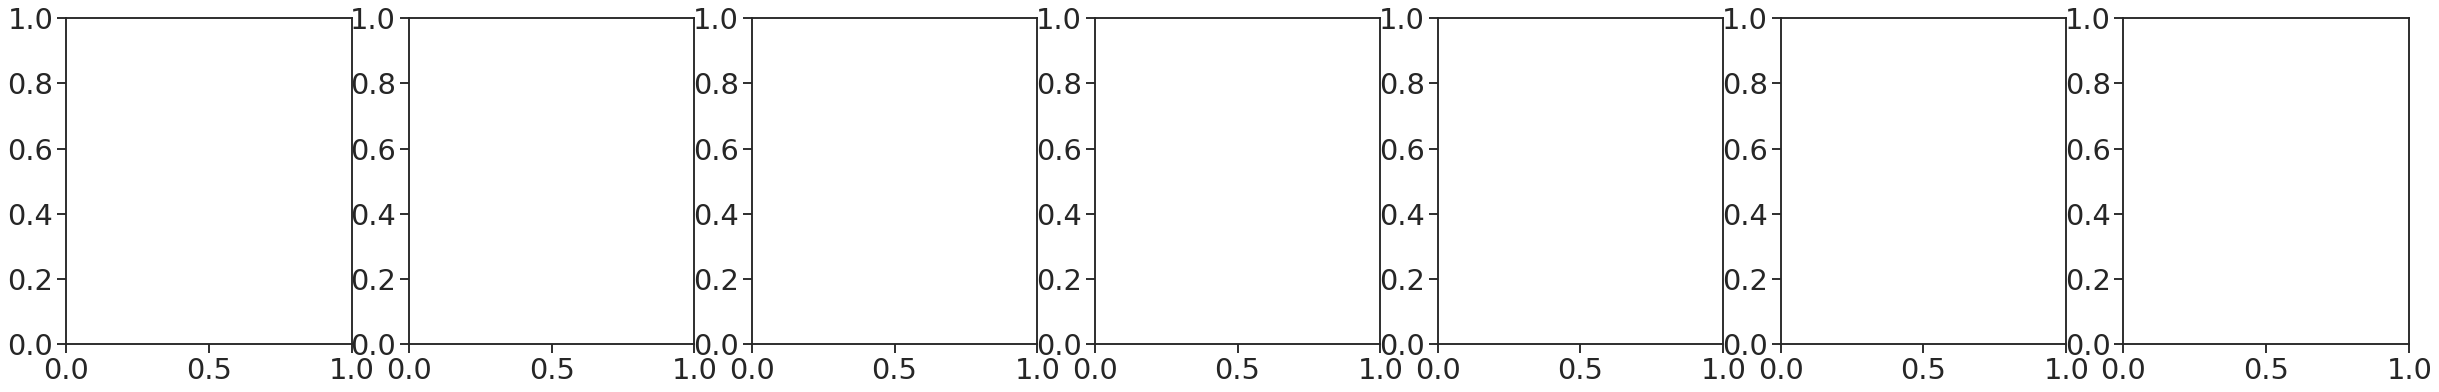

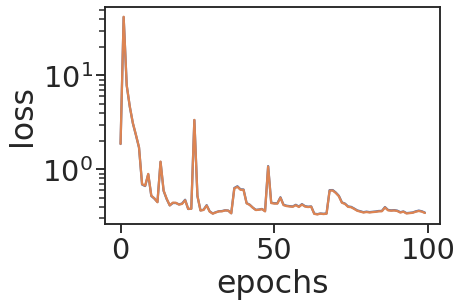

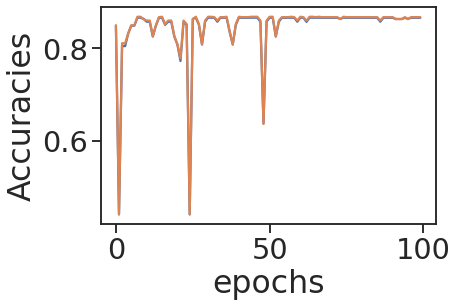

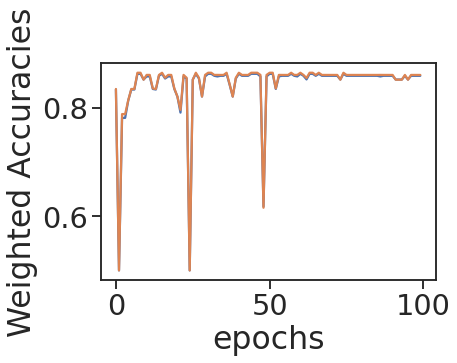

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

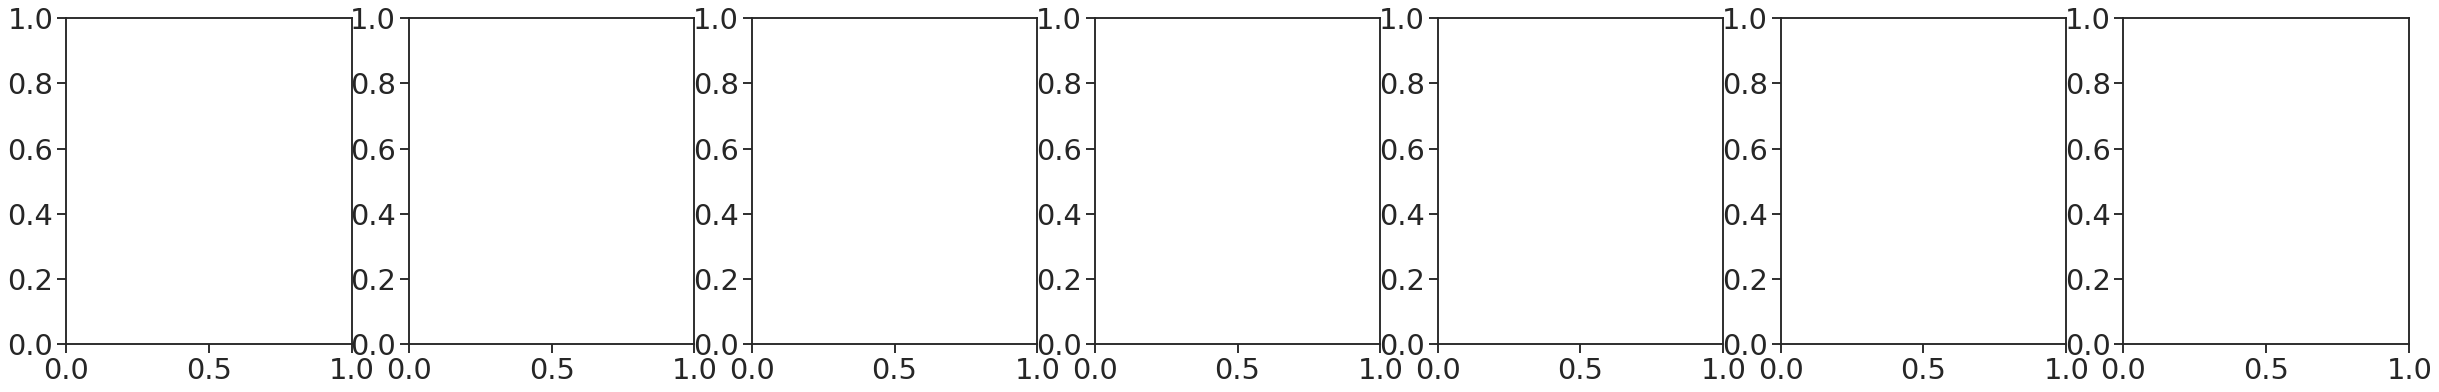

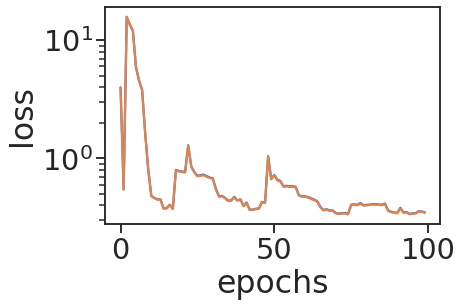

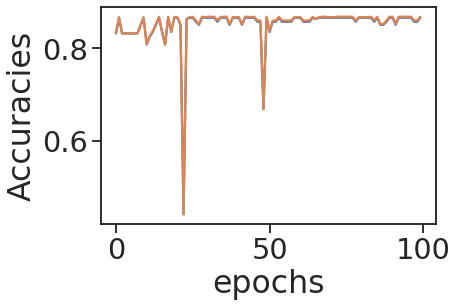

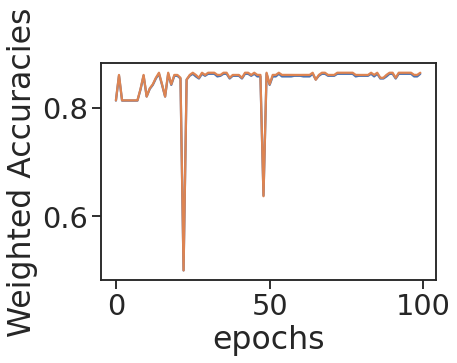

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

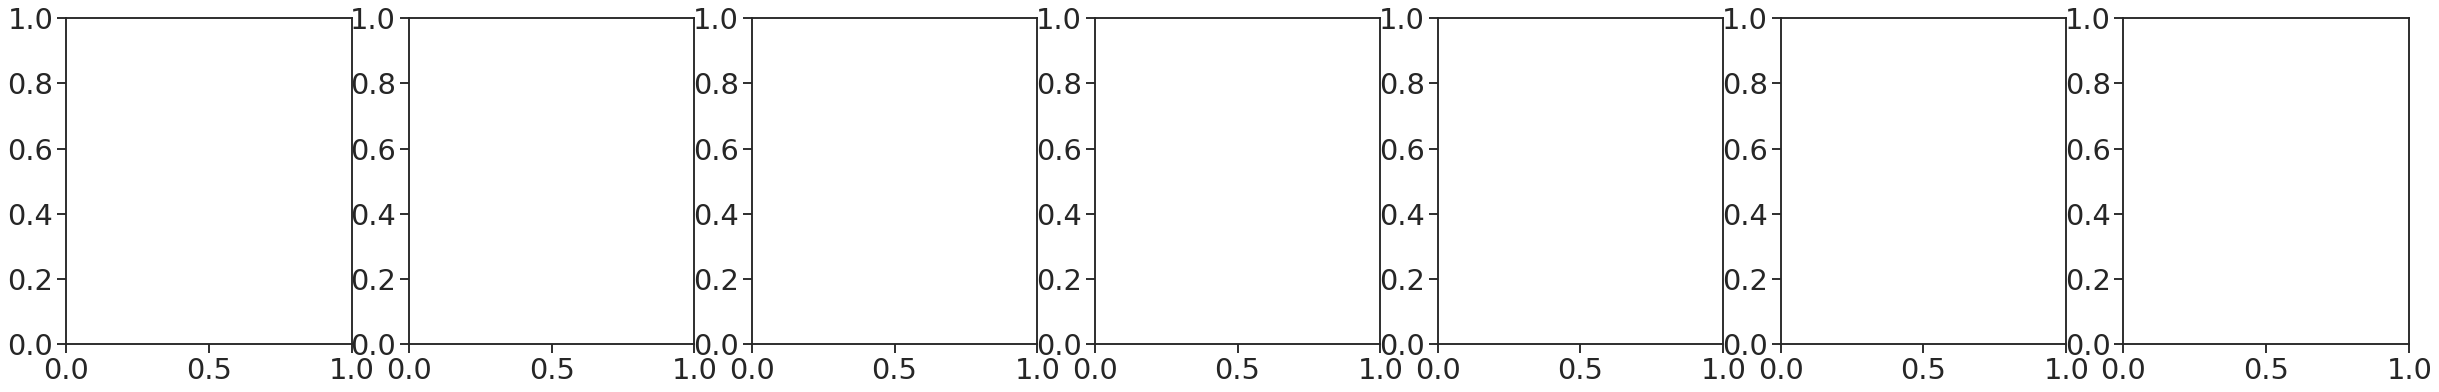

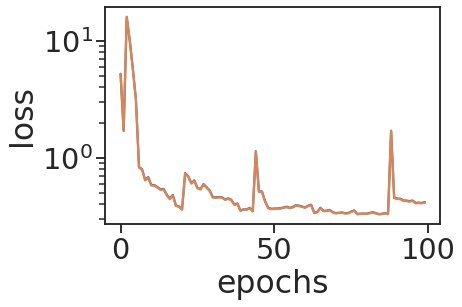

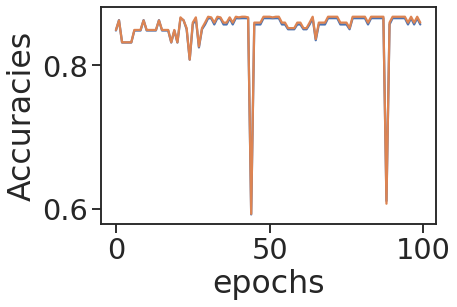

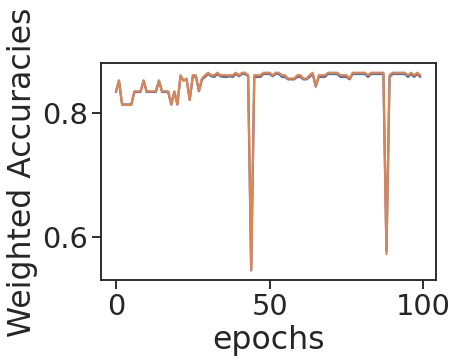

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

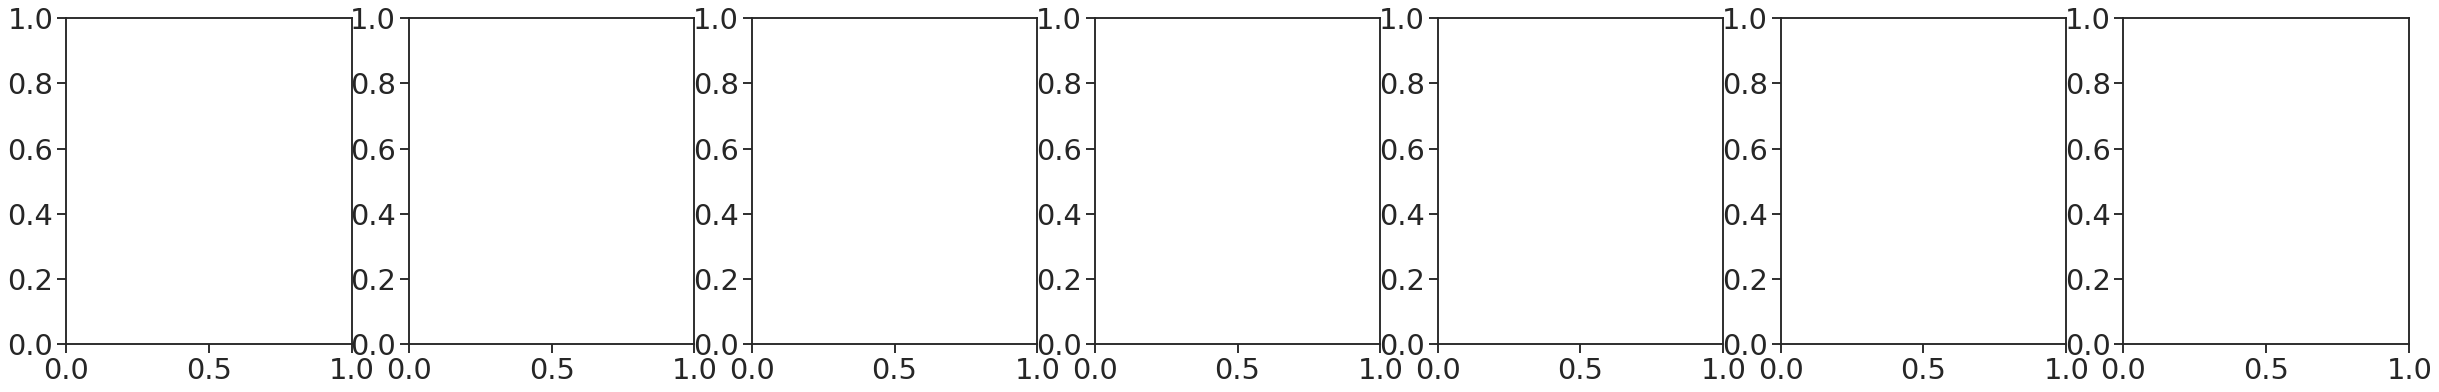

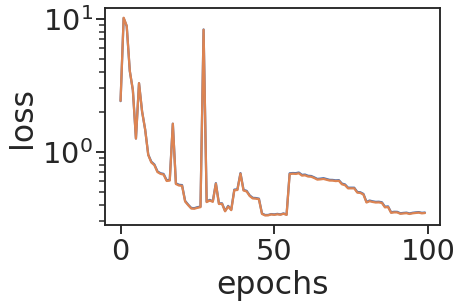

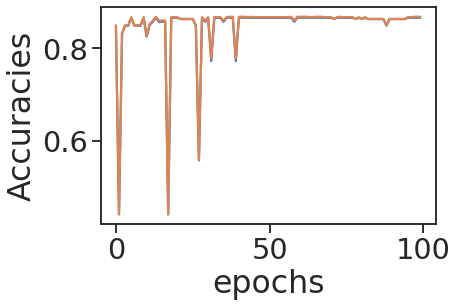

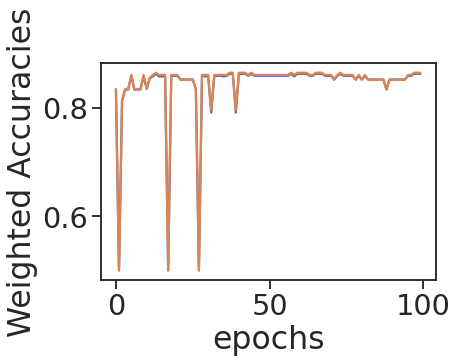

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

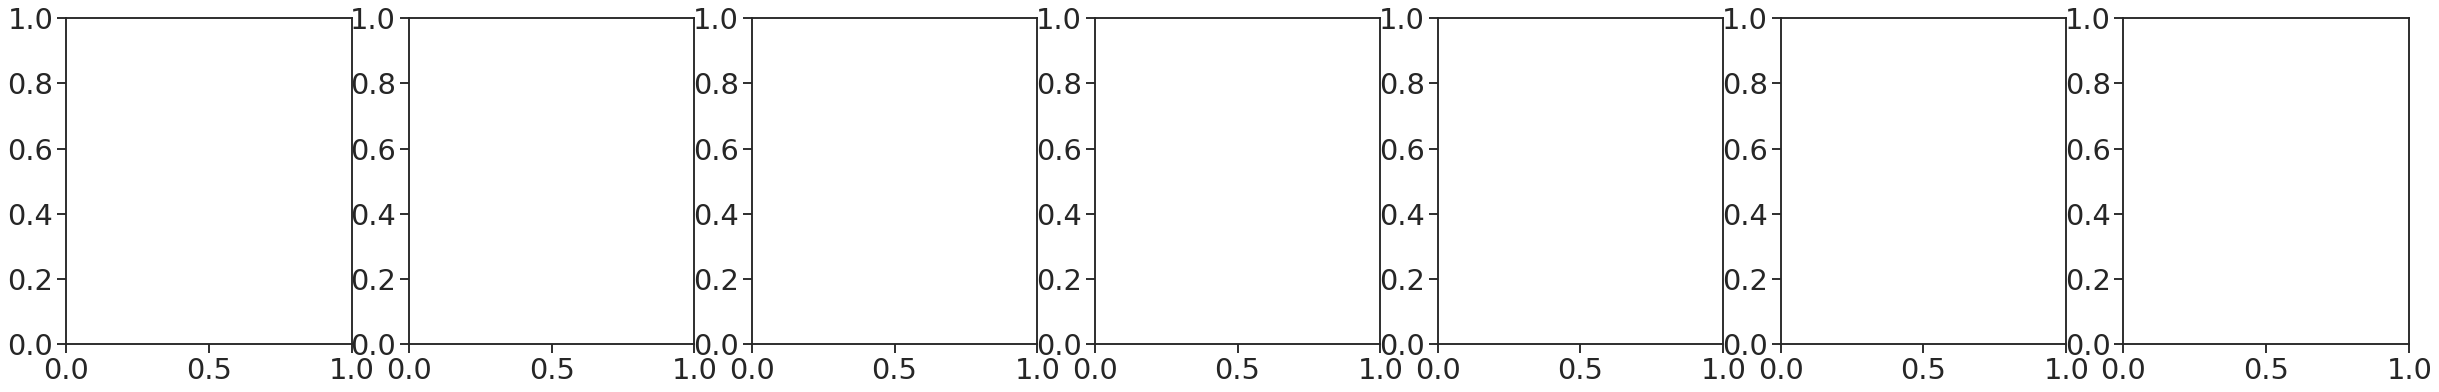

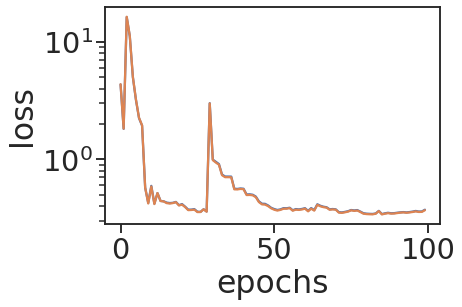

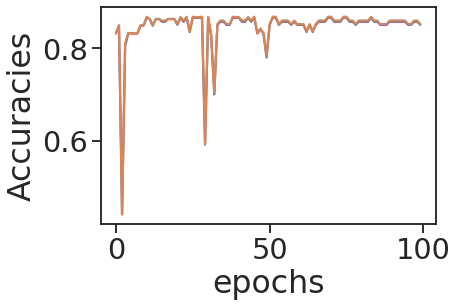

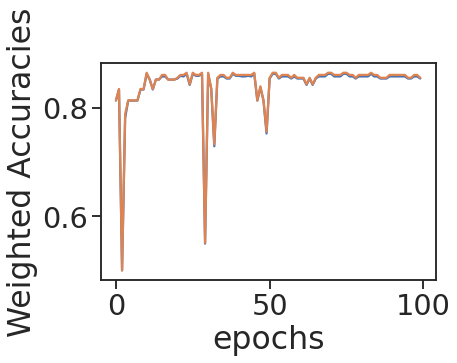

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)
n_epochs 100 total_time_steps 200 period_osc 5.0 batch_size 20
starting simulation np.shape(loss_list) (0,) np.shape(loss_list_test) (0,)
NEW SIMULATION. SEED:  0
NN initialized 
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on class:  0
New Period. Focus on class:  1
New Period. Focus on cl

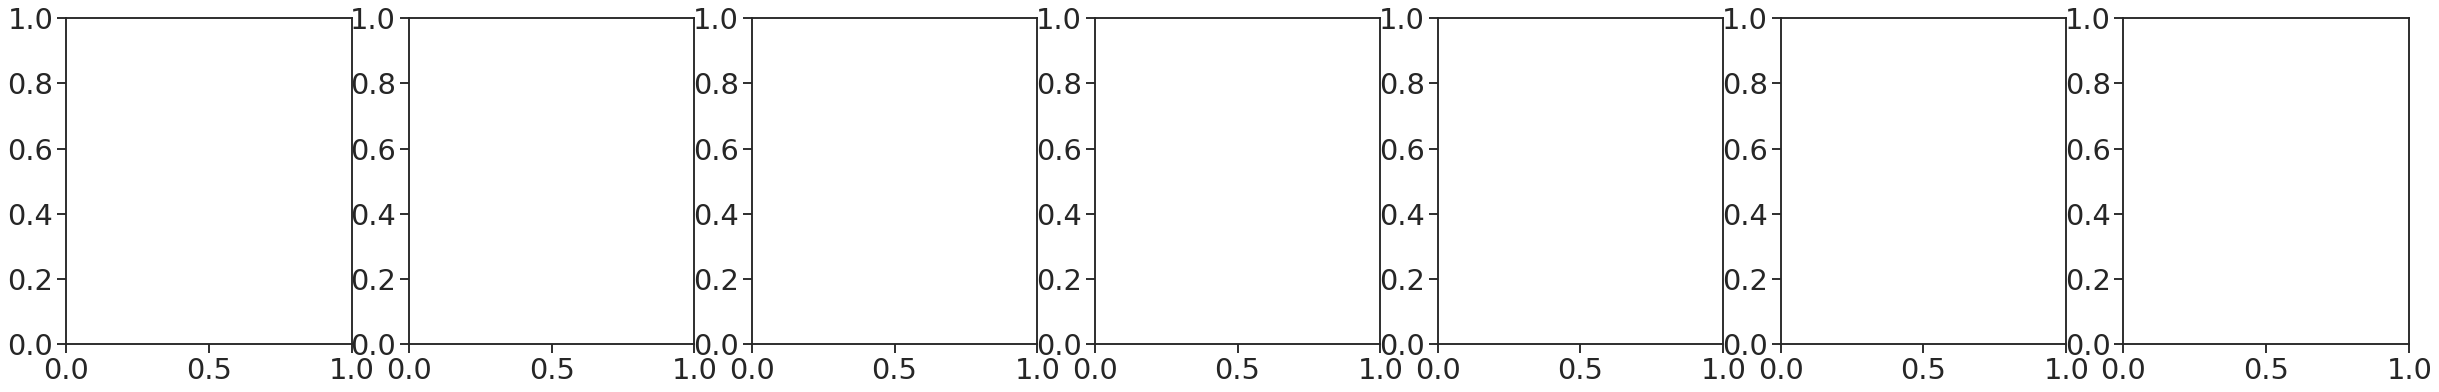

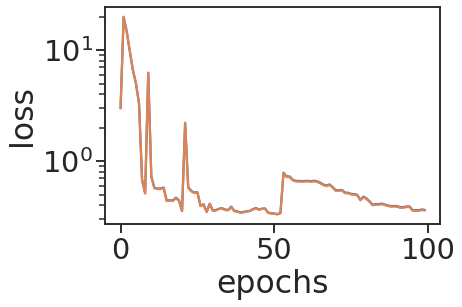

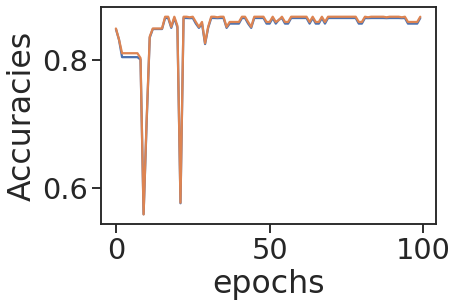

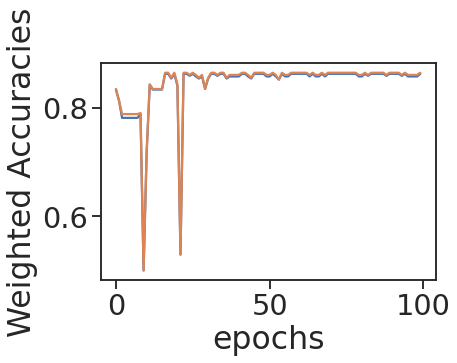

before saving np.shape(loss_list) (0,) np.shape(loss_test_save) (100,)
after saving np.shape(loss_list) (1, 100) np.shape(loss_list_test) (1, 100)


In [26]:
GD_folder_results = '.'
num_sim_ave = 10

final_acc_influ = []
models_save_influ = []
for ind_ave in range(num_sim_ave):
    tr_ac_1_st_influ, tr_ac_w_1_st_influ, test_ac_1_st_influ, test_ac_w_1_st_influ, model_t_99_st_influ = train_NN_new(x_two_cl_train_torch_strong_col_3, y_two_cl_train_torch_strong_col_3, x_two_cl_test_torch_strong_col_3, y_two_cl_test_torch_strong_col_3, train_with = [ ], add_friend_influence = True, proportion_train_test = proportion_train_test_strong)
    models_save_influ += [model_t_99_st_influ]
    final_acc_influ += [test_ac_w_1_st_influ]
    


Plotting the average probability learnt by the 10 NN trainined above.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<function matplotlib.pyplot.show(*args, **kw)>

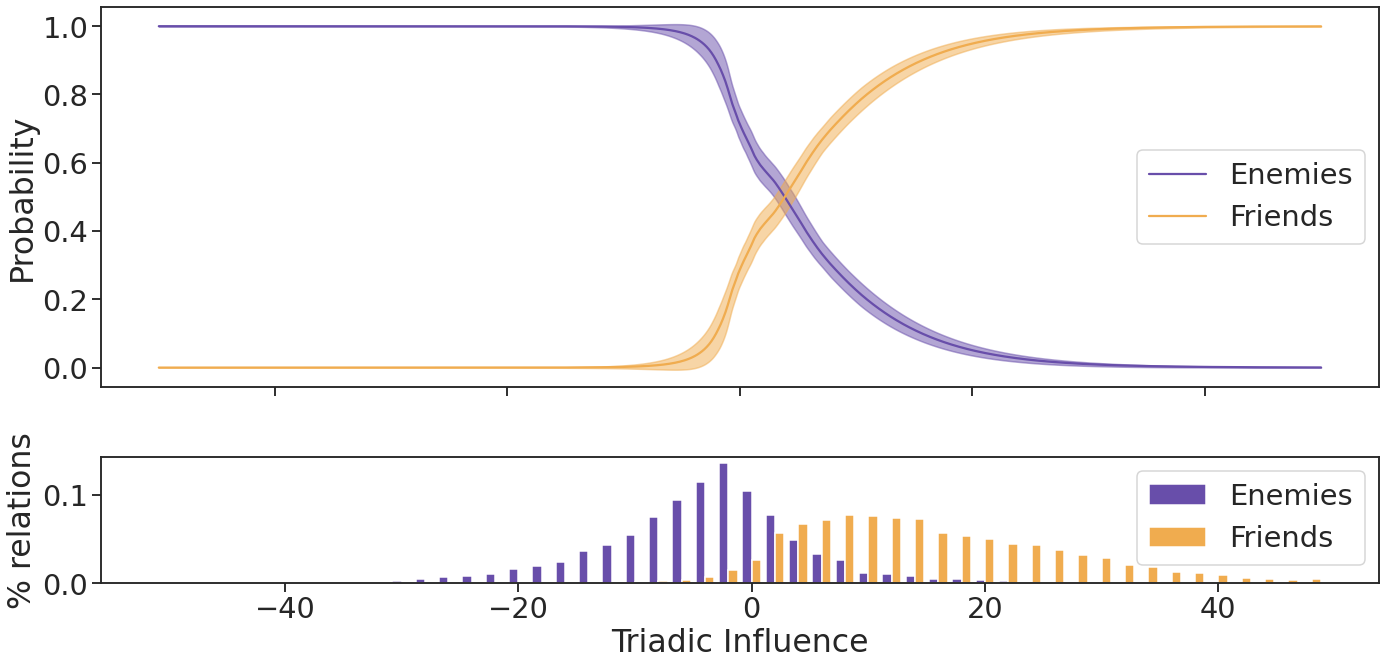

In [27]:
GD_folder_figures = '.'

Z_plot = np.linspace(-50,50,1000)
enemies_prob_list = []
friends_prob_list = []

for mod_i in models_save_influ:
    enemies_prob_list += [mod_i.input_skills_only_inf(Z_plot).detach().numpy()[:,0]]
    friends_prob_list += [mod_i.input_skills_only_inf(Z_plot).detach().numpy()[:,1]]

enemies_prob_list = np.array(enemies_prob_list)
friends_prob_list = np.array(friends_prob_list)

fig_prob_linear, (a1_pl, a2_pl) = plt.subplots(2, 1, figsize = (20,10), gridspec_kw={'height_ratios': [ 3, 1]})

Z_plot = np.linspace(-50,50,1000)

enemies_prob_col_1_s = np.mean(enemies_prob_list, axis=0)
friends_prob_col_1_s = np.mean(friends_prob_list, axis=0)

enemies_prob_std = np.std(enemies_prob_list, axis=0)
friends_prob_std = np.std(friends_prob_list, axis=0)

color_enemies = (104/255,78/255,170/255)
color_friends = (240/255,172/255,79/255)

a1_pl.plot(Z_plot,enemies_prob_col_1_s, label = 'Enemies', c = color_enemies)
a1_pl.fill_between(Z_plot,enemies_prob_col_1_s-enemies_prob_std,enemies_prob_col_1_s+enemies_prob_std, alpha=0.5, color = color_enemies)

a1_pl.plot(Z_plot,friends_prob_col_1_s, label = 'Friends', c = color_friends)
a1_pl.fill_between(Z_plot,friends_prob_col_1_s-friends_prob_std,friends_prob_col_1_s+friends_prob_std, alpha=0.5, color = color_friends)

a1_pl.set_xticklabels([])

a1_pl.set_ylabel('Probability')
a1_pl.legend()


infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (y_two_cl_train_torch_strong_col_3[aaa] == 0)])

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]

labels_plot = [label_ene_fri[aaa] for aaa in range(len(assess_all))]

a2_pl.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left', color = [color_enemies, color_friends]) #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
a2_pl.set_ylabel('% relations')
a2_pl.set_xlabel('Triadic Influence')
a2_pl.legend()

fig_prob_linear.tight_layout()
plt.show

Plotting the triadic influence distribution depending on the gender of the students forming the relationship

len(infl_male_male_friends) 12992


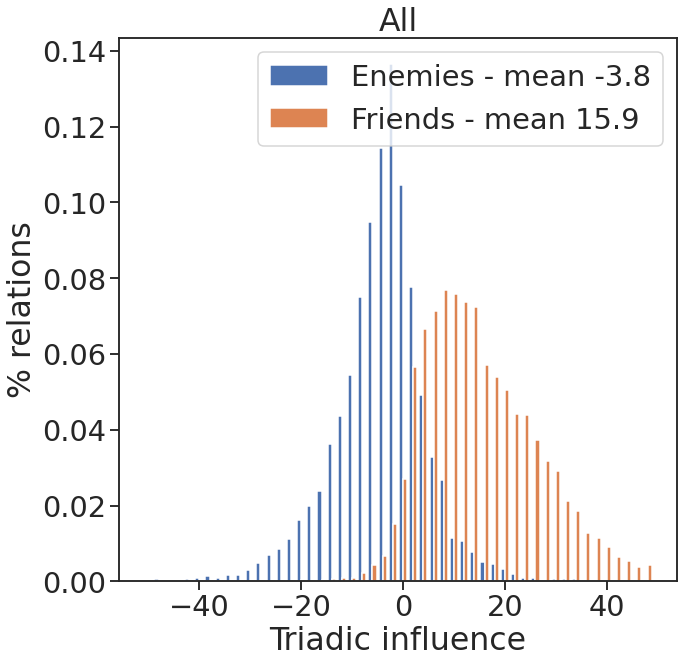

total_friends 5711


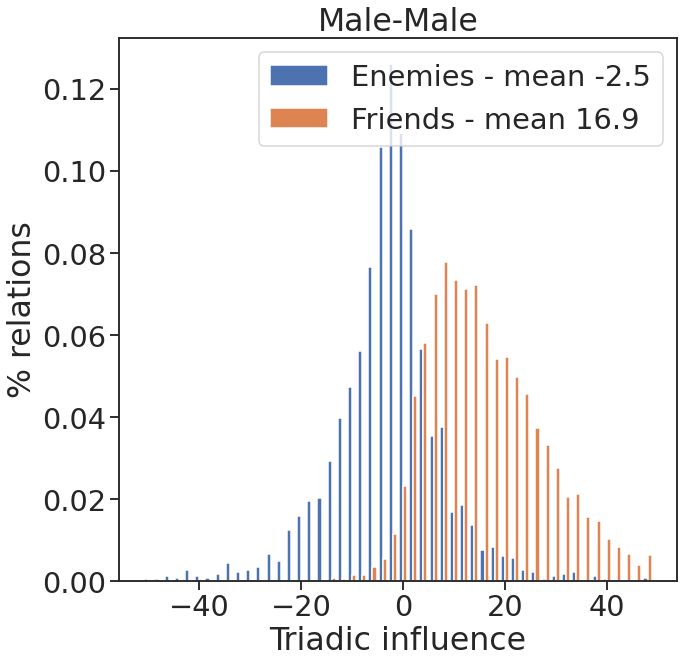

total_friends 9969


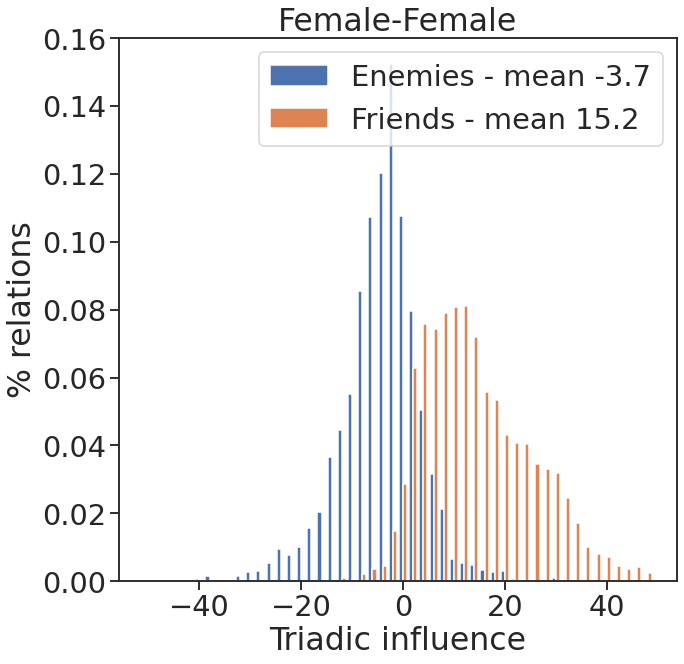

total_friends 11670


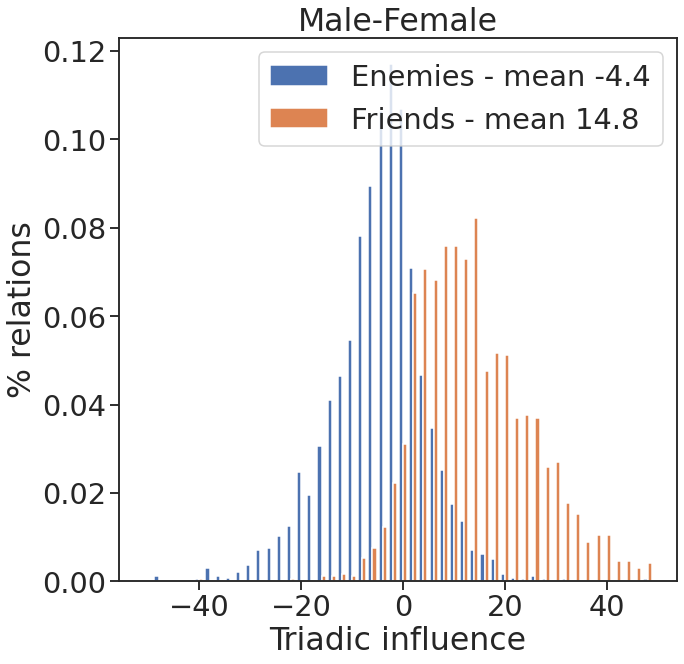

total_friends 12992


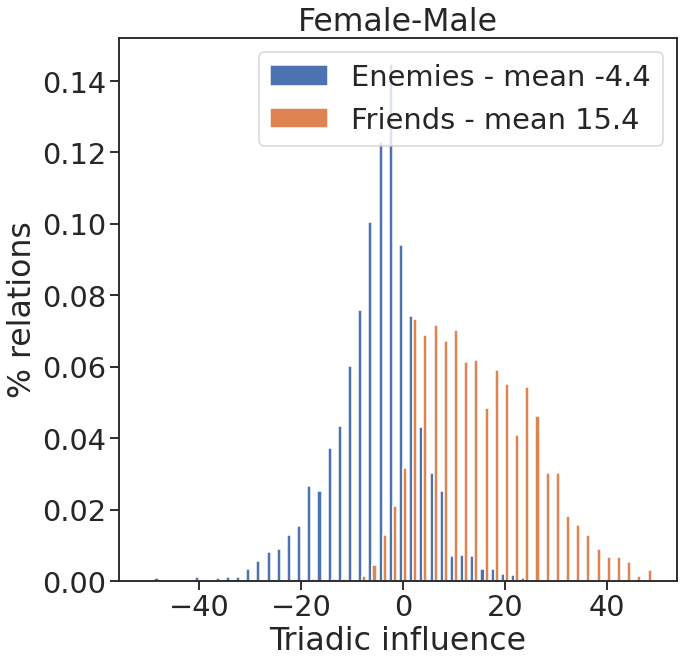

In [28]:

## HISTOGRAMS BY GENDERS

# ALL 
infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (y_two_cl_train_torch_strong_col_3[aaa] == 0)])

print('len(infl_male_male_friends)',len(infl_male_male_friends))

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

fig_hist = plt.figure(figsize=(10,10))

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]
labels_plot = [label_ene_fri[aaa] + ' - mean {:.1f}'.format(np.mean(assess_all[aaa])) for aaa in range(len(assess_all))]

plt.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left') #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
plt.ylabel('% relations')
plt.xlabel('Triadic influence')
plt.title('All')
plt.legend()
plt.show()

total_friends = 0

# MALE-MALE
infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 1 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 1 and y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 1 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 1 and y_two_cl_train_torch_strong_col_3[aaa] == 0)])

total_friends += len(infl_male_male_friends)
print('total_friends',total_friends)

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

fig_hist = plt.figure(figsize=(10,10))

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]
labels_plot = [label_ene_fri[aaa] + ' - mean {:.1f}'.format(np.mean(assess_all[aaa])) for aaa in range(len(assess_all))]

plt.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left') #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
plt.ylabel('% relations')
plt.xlabel('Triadic influence')
plt.title('Male-Male')
plt.legend()
plt.show()

# FEMALE-FEMALE
infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 0 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 0 and y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if (Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 0 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 0 and y_two_cl_train_torch_strong_col_3[aaa] == 0)])

total_friends += len(infl_male_male_friends)
print('total_friends',total_friends)

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

fig_hist = plt.figure(figsize=(10,10))

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]
labels_plot = [label_ene_fri[aaa] + ' - mean {:.1f}'.format(np.mean(assess_all[aaa])) for aaa in range(len(assess_all))]

plt.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left') #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
plt.ylabel('% relations')
plt.xlabel('Triadic influence')
plt.title('Female-Female')
plt.legend()
plt.show()

# MALE-FEMALE 
infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if ((Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 1 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 0) and y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if ((Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 1 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 0) and y_two_cl_train_torch_strong_col_3[aaa] == 0)])

total_friends += len(infl_male_male_friends)
print('total_friends',total_friends)

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

fig_hist = plt.figure(figsize=(10,10))

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]
labels_plot = [label_ene_fri[aaa] + ' - mean {:.1f}'.format(np.mean(assess_all[aaa])) for aaa in range(len(assess_all))]

plt.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left') #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
plt.ylabel('% relations')
plt.xlabel('Triadic influence')
plt.title('Male-Female')
plt.legend()
plt.show()

# FEMALE-MALE
infl_male_male_friends = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if ((Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 0 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 1) and y_two_cl_train_torch_strong_col_3[aaa] == 1)])
infl_male_male_enemies = np.array([ friend_influence_torch[x_two_cl_train_torch_strong_col_3[aaa,0],x_two_cl_train_torch_strong_col_3[aaa,1]]  for aaa in range(x_two_cl_train_torch_strong_col_3.shape[0]) if ((Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,0]] == 0 and Sexo_all_sort[x_two_cl_train_torch_strong_col_3[aaa,1]] == 1) and y_two_cl_train_torch_strong_col_3[aaa] == 0)])

total_friends += len(infl_male_male_friends)
print('total_friends',total_friends)

assess_all = [infl_male_male_enemies,infl_male_male_friends]
label_ene_fri = [ 'Enemies', 'Friends']

fig_hist = plt.figure(figsize=(10,10))

weights_plt=[np.ones(len(assess_all[aaa])) / len(assess_all[aaa]) for aaa in range(len(assess_all))]
labels_plot = [label_ene_fri[aaa] + ' - mean {:.1f}'.format(np.mean(assess_all[aaa])) for aaa in range(len(assess_all))]

plt.hist(assess_all, label=labels_plot, bins=np.linspace(-50,50,51), weights = weights_plt, align='left') #    label=['Male','Female'], bins=np.linspace(0,10,10),bins=range(60), align='left', #,  histtype=u'step', label =  key_ind, color = color_pl)
plt.ylabel('% relations')
plt.xlabel('Triadic influence')
plt.title('Female-Male')
plt.legend()
plt.show()

### Training the NN using only the prosociality of both students

Training 10 NN from scratch to average later

In [29]:

final_acc_pros = []
models_save_pros = []
for ind_ave in range(num_sim_ave):
    tr_ac_1_st_pros, tr_ac_w_1_st_pros, test_ac_1_st_pros, test_ac_w_1_st_pros, model_t_99_st_pros  = train_NN_new(x_two_cl_train_torch_strong_col_3, y_two_cl_train_torch_strong_col_3, x_two_cl_test_torch_strong_col_3, y_two_cl_test_torch_strong_col_3, train_with = [ 'prosocial'], add_friend_influence = False, proportion_train_test = proportion_train_test_strong)
    models_save_pros += [model_t_99_st_pros]
    final_acc_pros += [test_ac_w_1_st_pros]
    


Output hidden; open in https://colab.research.google.com to view.

Averaging the results

In [ ]:


titles = ['Probability Enemies','Probability Friends']

def plot_probabilities_paper(net_1,axs_1,fig,train_with):
  
  number_points_grid = 25
  x = np.linspace(0, 1, number_points_grid)
  y = np.linspace(0, 1, number_points_grid)
  X, Y = np.meshgrid(x, y)

  Zs = []
  for model_i in net_1:
      Z = model_i.input_skills_no_inf(X.flatten(), Y.flatten()).detach().numpy()
      Zs += [Z]

  Zs = np.array(Zs)

  print(np.shape(Z))
  print(np.shape(Zs))

  Z_mean = np.mean(Zs, axis=0)

  Z = Z_mean.reshape(number_points_grid,number_points_grid,Z_mean.shape[1])

  for ind_prob in range(0,Z.shape[2]):
      max_val = np.max(Z[:,:,ind_prob])
      min_val = np.min(Z[:,:,ind_prob])
      im = axs_1[ind_prob].contourf(X, Y, Z[:,:,ind_prob], 30, cmap='plasma' )# , vmin=0., vmax=1) #RdGy
      axs_1[ind_prob].set_xlabel(train_with[0] + ' (from)')
      axs_1[ind_prob].set_ylabel(train_with[0] + ' (to)')
      axs_1[ind_prob].set_title(titles[ind_prob])

      divider = make_axes_locatable(axs_1[ind_prob])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      cbar = fig.colorbar(im, cax=cax, orientation='vertical')

      cbar.set_ticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
      plt.tight_layout()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10),
                              constrained_layout=True)
plot_probabilities_paper(models_save_pros,axs,fig,['prosocial'])
plt.show()